# Panel Fixed Effects for Causal Inference

## The Causal Question

**What is the causal effect of a treatment on an outcome when units differ in unobserved ways?**

Consider a classic example: *What is the effect of job training on worker productivity?* The challenge is that workers who choose training may differ systematically from those who don't - perhaps more motivated or more able workers self-select into training programs. If we simply compare trained vs untrained workers, we conflate the effect of training with pre-existing differences between workers.

**Panel fixed effects** is a powerful method that can identify causal effects under specific conditions by exploiting within-unit variation over time. This notebook demonstrates:

1. **When fixed effects identifies causal effects** - the key assumptions
2. **How to implement it** - dummy variables vs within transformation
3. **When it fails** - limitations you must understand
4. **Connection to Difference-in-Differences** - TWFE as generalized DiD

:::{warning}
Fixed effects is not a magic solution. It only controls for **time-invariant** unobserved confounders. If there are time-varying confounders or reverse causality, fixed effects will still be biased.
:::

For accessible introductions to panel data and causal inference, see {cite:t}`cunningham2021causal` ([Chapter 8](https://mixtape.scunning.com/08-panel_data)) and {cite:t}`huntington2021effect`.

In [1]:
import warnings

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.linear_model import LinearRegression

import causalpy as cp

warnings.filterwarnings("ignore")

%config InlineBackend.figure_format = 'retina'
plt.style.use("default")

%load_ext autoreload
%autoreload 2

# Sampling settings for Bayesian models
sample_kwargs = {
    "draws": 2000,
    "tune": 1000,
    "chains": 4,
    "target_accept": 0.95,
    "random_seed": 42,
}

## Introduction to Panel Data

**Panel data** (also called longitudinal data) consists of observations on multiple units (individuals, firms, countries, etc.) observed over multiple time periods {cite:p}`wooldridge2010econometric`.

### The Problem: Omitted Variable Bias

Consider studying the effect of training on worker productivity:
- $y_{it}$ = productivity of worker $i$ at time $t$
- $X_{it}$ = 1 if worker received training, 0 otherwise
- $\alpha_i$ = innate ability of worker $i$ (unobserved!)

Problem: More able workers might self-select into training! Naive OLS will be biased.

### The Solution: Fixed Effects

Fixed effects estimation removes all time-invariant unit characteristics ($\alpha_i$), eliminating bias from unobserved confounders that don't change over time.

**Model:**

$$y_{it} = \beta_0 + \beta_1 X_{it} + \alpha_i + \epsilon_{it}$$

**Two equivalent approaches:**
1. **Dummy variables**: Include a dummy for each unit
2. **Within transformation**: Subtract unit-specific means from all variables

## Types of Fixed Effects

The `PanelRegression` class supports different fixed effects specifications depending on what confounders you need to control for.

### One-Way Fixed Effects

**Unit Fixed Effects Only** ($\alpha_i$): Controls for time-invariant unit characteristics.
- Use when: Units differ in unobserved ways that don't change over time
- Examples: Worker innate ability, firm culture, country geography
- CausalPy: Set `time_fe_variable=None` (the default)

**Time Fixed Effects Only** ($\gamma_t$): Controls for common time shocks affecting all units.
- Use when: All units experience common shocks each period
- Examples: Macroeconomic conditions, seasonal effects, policy changes
- CausalPy: Include `C(time)` in formula but omit `C(unit)`

### Two-Way Fixed Effects (TWFE)

**Both Unit and Time** ($\alpha_i + \gamma_t$): Controls for both sources of confounding.
- Use when: Both unit heterogeneity AND common time trends matter
- Most common in difference-in-differences style analyses
- CausalPy: Set both `unit_fe_variable` and `time_fe_variable`

| Type | Controls For | CausalPy Parameter |
|------|-------------|-------------------|
| Unit FE only | Time-invariant unit factors | `time_fe_variable=None` |
| Time FE only | Common period shocks | Use `C(time)` in formula |
| Two-way FE | Both | `time_fe_variable="time"` |

:::{note}
The choice between one-way and two-way fixed effects depends on your causal assumptions about what confounders exist. More fixed effects is not always better - it can reduce precision and eliminate variation needed for identification.
:::


## The Causal Framework: When Does Fixed Effects Work?

To understand when fixed effects identifies causal effects, we need to think about the causal structure. Following {cite:t}`imaikim2019fixed`, consider this simplified DAG:

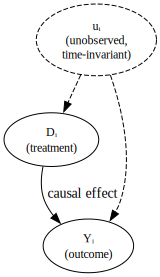

In [2]:
from graphviz import Digraph

# DAG showing time-invariant confounder
dag = Digraph(comment="Fixed Effects DAG")
dag.attr(rankdir="TB", size="6,4")
dag.attr("node", shape="ellipse", fontsize="12")

# Nodes
dag.node("U", "uᵢ\n(unobserved,\ntime-invariant)", style="dashed")
dag.node("D", "Dᵢₜ\n(treatment)")
dag.node("Y", "Yᵢₜ\n(outcome)")

# Edges
dag.edge("U", "D", style="dashed")
dag.edge("U", "Y", style="dashed")
dag.edge("D", "Y", label="  causal effect")

dag

Here:
- $D_{it}$ is the treatment for unit $i$ at time $t$
- $Y_{it}$ is the outcome
- $u_i$ is an **unobserved, time-invariant** characteristic (e.g., innate ability)

The unobserved $u_i$ creates a backdoor path: $D_{it} \leftarrow u_i \rightarrow Y_{it}$. This is the source of omitted variable bias.

### How Fixed Effects Solves This

Fixed effects works by comparing each unit **to itself over time**. Since $u_i$ doesn't change over time, any within-unit changes in $Y$ must be due to changes in $D$ (or other time-varying factors).

Mathematically, the within transformation subtracts unit means:

$$\tilde{Y}_{it} = Y_{it} - \bar{Y}_i$$
$$\tilde{D}_{it} = D_{it} - \bar{D}_i$$

Since $u_i - \bar{u}_i = 0$, the confounder is eliminated!

### What must be true for this to work

The DAG above shows what we **need** (time-invariant confounding). But equally important is what must be **absent**:


## Identifying Assumptions

For fixed effects to identify the causal effect of $D$ on $Y$, we need:

### 1. Strict Exogeneity (No Feedback)

Past, present, and future values of treatment must be uncorrelated with the idiosyncratic error:

$$E[\epsilon_{it} | D_{i1}, D_{i2}, ..., D_{iT}, u_i] = 0$$

**In plain language:** 
- Past outcomes don't affect current treatment (no feedback loops)
- Future treatment doesn't affect current outcomes (no anticipation)
- Current shocks don't affect future treatment

:::{note}
This rules out dynamic models where $Y_{t-1}$ affects $D_t$. For example, if poor sales (outcome) lead a firm to adopt a new technology (treatment), strict exogeneity is violated.
:::

### 2. No Time-Varying Confounders

The only unobserved confounders are time-invariant. If there are unobserved factors that:
- Change over time, AND
- Affect both treatment and outcome

...then fixed effects will be biased.

### 3. Treatment Varies Within Units

If treatment never changes for a unit (always treated or never treated), that unit contributes no information to the estimate. We identify the effect from units whose treatment status changes.

### 4. Parallel Trends (for Two-Way FE)

When including time fixed effects, we implicitly assume that absent treatment, all units would follow parallel trends. This connects directly to the difference-in-differences assumption.


## Example 1: One-Way Fixed Effects (Unit Only)

This example demonstrates **one-way unit fixed effects** - we control for time-invariant unit characteristics but NOT for common time trends.

**When is this appropriate?**
- Time trends are not a major concern (no common shocks affecting all units)
- Or time effects are captured by covariates in the model
- You want to preserve cross-sectional variation that time FE would remove

Let's simulate panel data where we know the true treatment effect. This example is designed to satisfy all the identifying assumptions:

- ✅ Time-invariant confounders only (unit effects)
- ✅ No feedback from outcomes to treatment
- ✅ No time-varying confounders
- ✅ Treatment varies within units over time

**Causal Question:** What is the effect of treatment on the outcome, controlling for unobserved unit-level heterogeneity?

In [3]:
# Set random seed
np.random.seed(42)

# Panel dimensions
n_units = 20
n_periods = 15
treatment_time = 10

# True parameters
TRUE_TREATMENT_EFFECT = 3.0
TRUE_X_COEF = 0.5

# Generate panel data
data = []
for i in range(n_units):
    unit_effect = np.random.randn() * 2.0

    for t in range(n_periods):
        x1 = np.random.randn()
        treatment = 1 if (t >= treatment_time and i < n_units // 2) else 0

        y = (
            unit_effect
            + TRUE_TREATMENT_EFFECT * treatment
            + TRUE_X_COEF * x1
            + np.random.randn() * 0.5
        )

        data.append(
            {
                "unit": f"unit_{i}",
                "time": t,
                "treatment": treatment,
                "x1": x1,
                "y": y,
            }
        )

df_sim = pd.DataFrame(data)
print(f"Panel: {n_units} units, {n_periods} periods")
print(f"True treatment effect: {TRUE_TREATMENT_EFFECT}")
df_sim.head()

Panel: 20 units, 15 periods
True treatment effect: 3.0


,unit,time,treatment,x1,y
0,unit_0,0,0,-0.138264,1.248140
1,unit_0,1,0,1.523030,1.637867
2,unit_0,2,0,-0.234137,1.665966
3,unit_0,3,0,0.767435,1.142408
4,unit_0,4,0,0.542560,1.032999


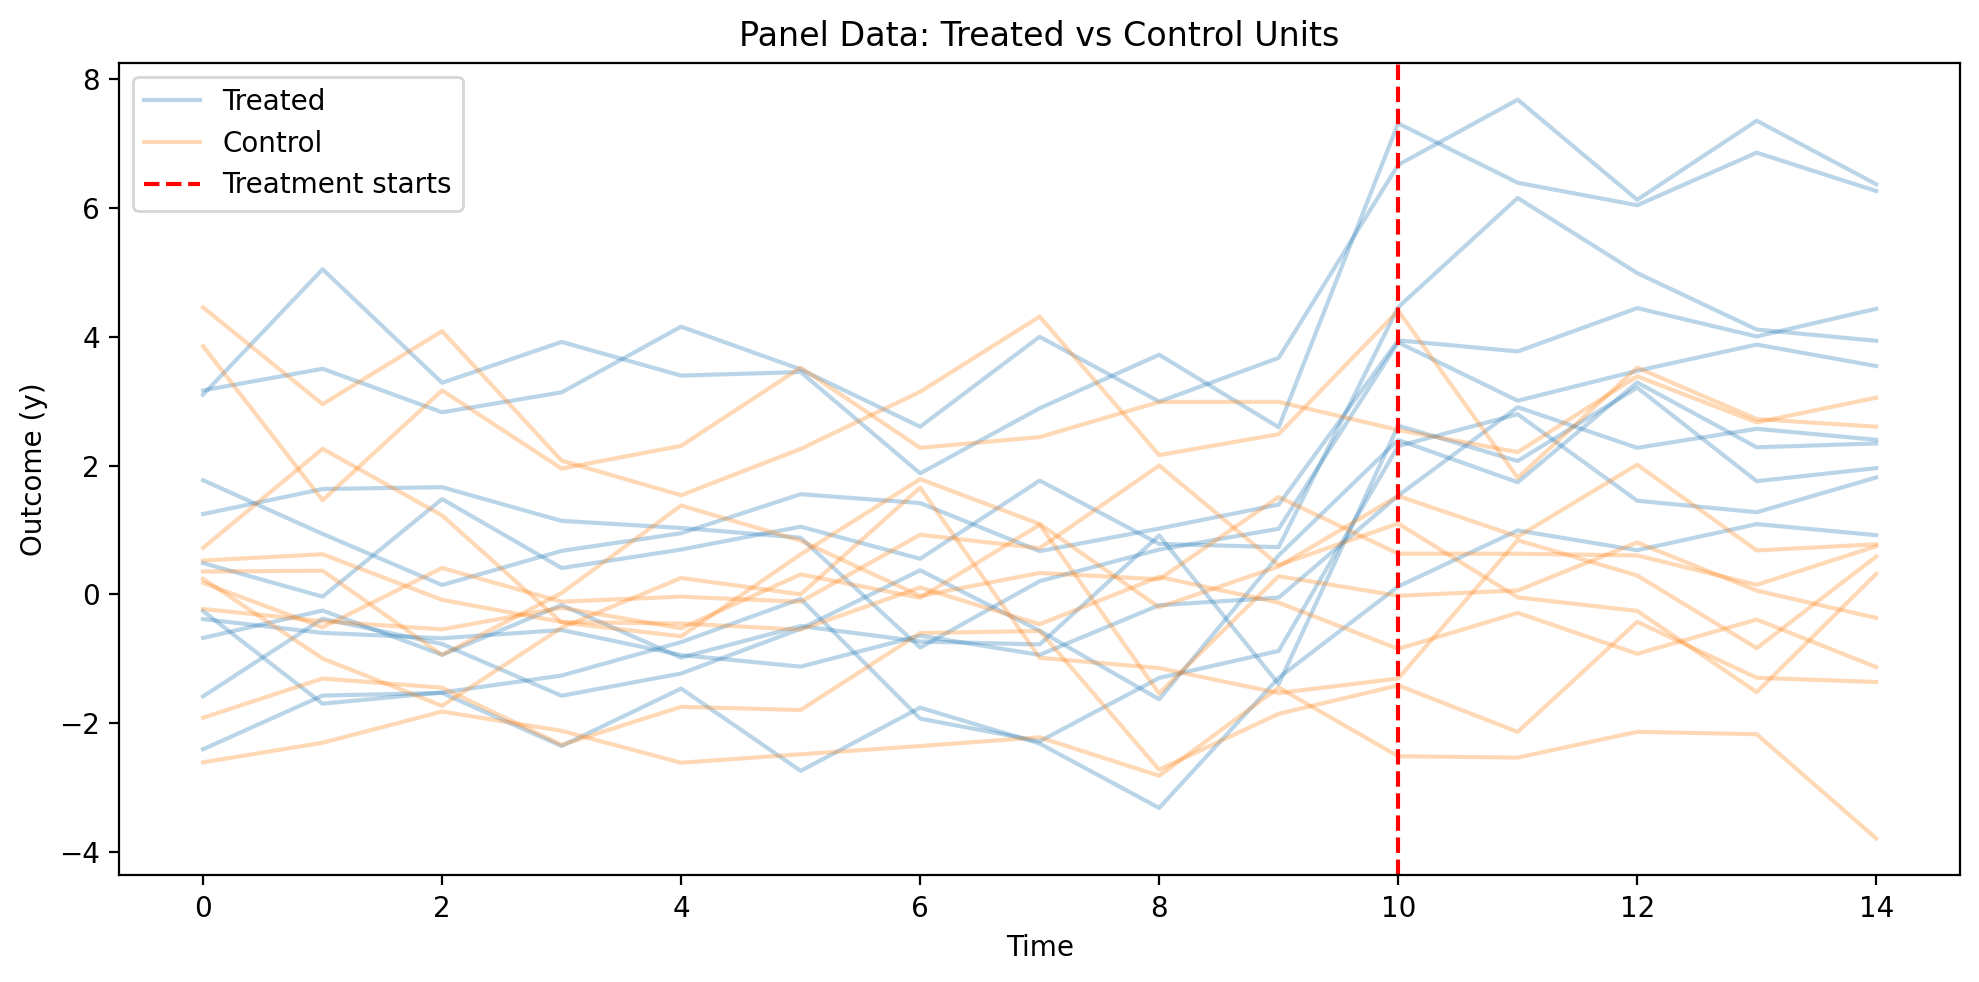

In [4]:
# Visualize the simulated panel data
fig, ax = plt.subplots(figsize=(10, 5))

# Add treatment group indicator
df_sim["group"] = df_sim["unit"].apply(
    lambda x: "Treated" if int(x.split("_")[1]) < 10 else "Control"
)

sns.lineplot(
    data=df_sim,
    x="time",
    y="y",
    hue="group",
    units="unit",
    estimator=None,
    alpha=0.3,
    ax=ax,
)
ax.axvline(x=treatment_time, color="red", linestyle="--", label="Treatment starts")
ax.set_xlabel("Time")
ax.set_ylabel("Outcome (y)")
ax.set_title("Panel Data: Treated vs Control Units")
ax.legend()
plt.tight_layout()

### Naive OLS (Biased)

First, let's see what happens if we ignore the unit fixed effects:

In [5]:
# Naive OLS without fixed effects
X_naive = df_sim[["treatment", "x1"]].values
y_naive = df_sim["y"].values

naive_model = LinearRegression().fit(X_naive, y_naive)
print("Naive OLS (NO fixed effects):")
print(f"  Treatment effect: {naive_model.coef_[0]:.3f} (True: {TRUE_TREATMENT_EFFECT})")
print(f"  Bias: {naive_model.coef_[0] - TRUE_TREATMENT_EFFECT:.3f}")

Naive OLS (NO fixed effects):
  Treatment effect: 3.219 (True: 3.0)
  Bias: 0.219


### Fixed Effects with Dummies

In [6]:
# One-way unit FE with dummy variables (Bayesian)
# Note: time_fe_variable is not set, so we only control for unit effects
result_dummies = cp.PanelRegression(
    data=df_sim,
    formula="y ~ C(unit) + treatment + x1",  # No C(time) - unit FE only
    unit_fe_variable="unit",
    fe_method="dummies",
    model=cp.pymc_models.LinearRegression(sample_kwargs=sample_kwargs),
)

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta, y_hat_sigma]


Output()

Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 2 seconds.
Sampling: [beta, y_hat, y_hat_sigma]
Sampling: [y_hat]


In [7]:
result_dummies.summary()


Panel Regression
Units: 20 (unit)
FE method: dummies
Observations: 300

Note: 19 fixed effect coefficients not shown (use print_coefficients() to see all)

Model Coefficients (excluding FE dummies):
Model coefficients:
    Intercept    0.82, 94% HDI [0.58, 1.1]
    treatment    3.1, 94% HDI [2.9, 3.3]
    x1           0.48, 94% HDI [0.42, 0.53]
    y_hat_sigma  0.49, 94% HDI [0.46, 0.54]


### Fixed Effects with Within Transformation

The within transformation gives identical results:

In [8]:
# One-way unit FE with within transformation (Bayesian)
# Note: time_fe_variable is not set, so we only control for unit effects
result_within = cp.PanelRegression(
    data=df_sim,
    formula="y ~ treatment + x1",  # No C(unit) needed with within transformation!
    unit_fe_variable="unit",
    # time_fe_variable not set = one-way unit FE
    fe_method="within",
    model=cp.pymc_models.LinearRegression(sample_kwargs=sample_kwargs),
)

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta, y_hat_sigma]


Output()

Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 1 seconds.
Sampling: [beta, y_hat, y_hat_sigma]
Sampling: [y_hat]


In [9]:
result_within.summary()


Panel Regression
Units: 20 (unit)
FE method: within
Observations: 300

Model Coefficients (excluding FE dummies):
Model coefficients:
    Intercept    -0.00025, 94% HDI [-0.053, 0.051]
    treatment    3.1, 94% HDI [3, 3.3]
    x1           0.48, 94% HDI [0.42, 0.53]
    y_hat_sigma  0.48, 94% HDI [0.44, 0.52]


### Interpreting the Results

The treatment coefficient of approximately **3.1** (true value: 3.0) represents the **within-unit causal effect** of treatment on the outcome. 

**What this means:** For the same unit, receiving treatment increases the outcome by about 3 units on average, after controlling for all time-invariant unit characteristics.

**Key insight:** This estimate comes from comparing each unit to *itself* at different time points - not from comparing treated units to control units. This is why fixed effects can control for unobserved unit-level confounders.

The Bayesian credible interval provides uncertainty quantification: we're 94% confident the true effect lies within this range.


### Comparing One-Way vs Two-Way Fixed Effects

What happens if we add time fixed effects to the same data? Let's compare:

1. **One-way (unit only):** What we just estimated above
2. **Two-way (unit + time):** Adding time fixed effects

This comparison helps illustrate when the choice matters.


In [10]:
# Two-way FE: Add time fixed effects to the same data
result_twoway = cp.PanelRegression(
    data=df_sim,
    formula="y ~ treatment + x1",  # Within transformation handles both unit and time
    unit_fe_variable="unit",
    time_fe_variable="time",  # <-- This adds time FE!
    fe_method="within",
    model=cp.pymc_models.LinearRegression(sample_kwargs=sample_kwargs),
)

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta, y_hat_sigma]


Output()

Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 1 seconds.
Sampling: [beta, y_hat, y_hat_sigma]
Sampling: [y_hat]


In [11]:
# Compare the treatment effect estimates
print("=" * 60)
print("COMPARISON: One-Way vs Two-Way Fixed Effects")
print("=" * 60)
print(f"\nTrue treatment effect: 3.0")
print(f"\nOne-way (unit FE only):")
print(
    f"  Treatment coefficient: {result_within.model.idata.posterior['beta'].sel(coeffs='treatment').mean().values:.3f}"
)
print(f"\nTwo-way (unit + time FE):")
print(
    f"  Treatment coefficient: {result_twoway.model.idata.posterior['beta'].sel(coeffs='treatment').mean().values:.3f}"
)
print("\nIn this case, both estimates are similar because the simulated data")
print("doesn't have strong common time trends that confound treatment.")

COMPARISON: One-Way vs Two-Way Fixed Effects

True treatment effect: 3.0

One-way (unit FE only):
  Treatment coefficient: 3.107

Two-way (unit + time FE):
  Treatment coefficient: 3.125

In this case, both estimates are similar because the simulated data
doesn't have strong common time trends that confound treatment.


:::{tip}
**When does the choice matter?**

The estimates from one-way and two-way FE will differ when:
- There are **common time shocks** (e.g., a recession affecting all units) that correlate with treatment
- Treatment rollout is **correlated with time trends** (e.g., early adopters vs late adopters)

If neither condition applies, one-way unit FE is often sufficient and more parsimonious.
:::


## Example 2: When Fixed Effects Fails

The simulation above worked because our data satisfied all the identifying assumptions. But what happens when assumptions are violated?

### Violation: Time-Varying Confounders

Let's add a **time-varying confounder** that affects both treatment and outcome. This could represent, for example, a local economic shock that both:
- Makes workers more likely to seek training (affects treatment)
- Independently affects productivity (affects outcome)

Fixed effects **cannot** remove this confounder because it changes over time.


In [12]:
# Simulate data with a TIME-VARYING confounder
np.random.seed(42)

n_units = 20
n_periods = 15
TRUE_TREATMENT_EFFECT = 3.0  # Same as before

data_violation = []
for i in range(n_units):
    unit_effect = np.random.randn() * 2.0  # Time-invariant (FE handles this)

    for t in range(n_periods):
        # TIME-VARYING confounder: an economic shock that varies by unit AND time
        economic_shock = np.random.randn() * 1.5

        # Treatment is AFFECTED by the economic shock (more likely to train during good times)
        treatment_propensity = 0.3 + 0.3 * (economic_shock > 0)
        treatment = 1 if (np.random.rand() < treatment_propensity and t >= 5) else 0

        # Outcome is affected by treatment AND the economic shock
        y = (
            unit_effect
            + TRUE_TREATMENT_EFFECT * treatment
            + 2.0 * economic_shock  # Direct effect of confounder on outcome
            + np.random.randn() * 0.5
        )

        data_violation.append(
            {"unit": f"unit_{i}", "time": t, "treatment": treatment, "y": y}
        )

df_violation = pd.DataFrame(data_violation)

In [13]:
# Apply fixed effects
result_violation = cp.PanelRegression(
    data=df_violation,
    formula="y ~ treatment",
    unit_fe_variable="unit",
    fe_method="within",
    model=LinearRegression(),
)

In [14]:
treatment_idx = result_violation.labels.index("treatment")
biased_estimate = result_violation.model.coef_[treatment_idx]

print("=" * 60)
print("FIXED EFFECTS WITH TIME-VARYING CONFOUNDER")
print("=" * 60)
print(f"True treatment effect:      {TRUE_TREATMENT_EFFECT:.2f}")
print(f"FE estimate:                {biased_estimate:.2f}")
print(f"Bias:                       {biased_estimate - TRUE_TREATMENT_EFFECT:.2f}")
print()
print("⚠️  The estimate is BIASED because the economic shock")
print("   affects both treatment and outcome, and FE cannot remove it!")
print("=" * 60)

FIXED EFFECTS WITH TIME-VARYING CONFOUNDER
True treatment effect:      3.00
FE estimate:                3.91
Bias:                       0.91

⚠️  The estimate is BIASED because the economic shock
   affects both treatment and outcome, and FE cannot remove it!


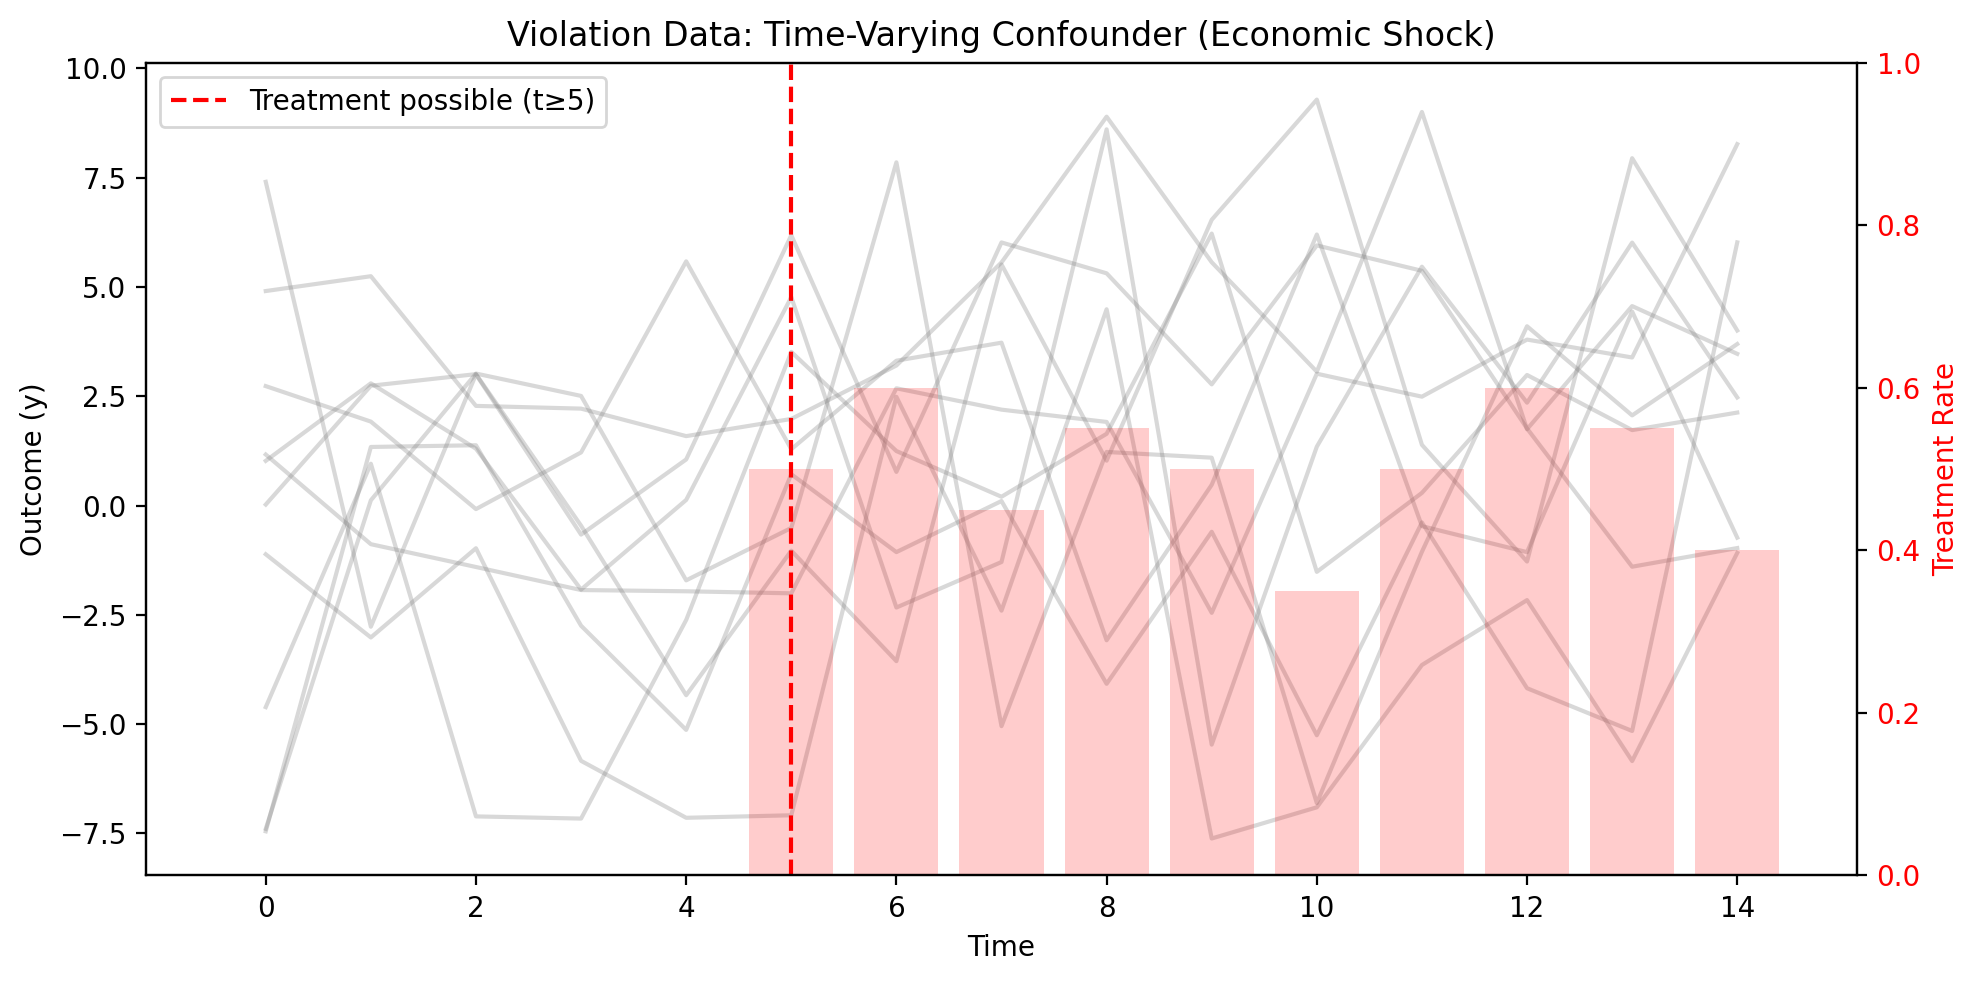

In [15]:
# Visualize the violation data
# Note: Treatment is stochastic here, so we show average treated proportion by time
fig, ax = plt.subplots(figsize=(10, 5))

# Calculate treatment rate by time
treatment_rate = df_violation.groupby("time")["treatment"].mean()
ax2 = ax.twinx()
ax2.bar(
    treatment_rate.index,
    treatment_rate.values,
    alpha=0.2,
    color="red",
    label="Treatment rate",
)
ax2.set_ylabel("Treatment Rate", color="red")
ax2.tick_params(axis="y", labelcolor="red")
ax2.set_ylim(0, 1)

# Plot individual trajectories
for unit in df_violation["unit"].unique()[:10]:  # Sample 10 units
    unit_data = df_violation[df_violation["unit"] == unit]
    ax.plot(unit_data["time"], unit_data["y"], alpha=0.3, color="gray")

ax.axvline(x=5, color="red", linestyle="--", label="Treatment possible (t≥5)")
ax.set_xlabel("Time")
ax.set_ylabel("Outcome (y)")
ax.set_title("Violation Data: Time-Varying Confounder (Economic Shock)")
ax.legend(loc="upper left")
plt.tight_layout()

### The Lesson

This example demonstrates a critical limitation: **fixed effects only removes time-invariant confounders**. 

In the DAG terms from earlier, if we add a time-varying confounder $v_{it}$:


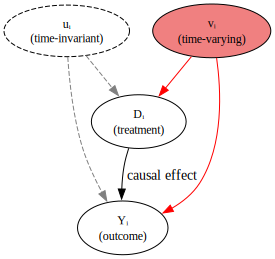

In [16]:
# DAG showing both time-invariant AND time-varying confounders
dag_violation = Digraph(comment="FE Violation DAG")
dag_violation.attr(rankdir="TB", size="7,4")
dag_violation.attr("node", shape="ellipse", fontsize="12")

# Nodes
dag_violation.node("U", "uᵢ\n(time-invariant)", style="dashed")
dag_violation.node("V", "vᵢₜ\n(time-varying)", style="filled", fillcolor="lightcoral")
dag_violation.node("D", "Dᵢₜ\n(treatment)")
dag_violation.node("Y", "Yᵢₜ\n(outcome)")

# Edges - u_i is removed by FE (crossed out conceptually)
dag_violation.edge("U", "D", style="dashed", color="gray")
dag_violation.edge("U", "Y", style="dashed", color="gray")
dag_violation.edge("V", "D", color="red")  # This path is NOT removed
dag_violation.edge("V", "Y", color="red")  # This path is NOT removed
dag_violation.edge("D", "Y", label="  causal effect")

dag_violation

Fixed effects eliminates the $u_i$ backdoor path (gray, dashed) but **not** the $v_{it}$ path (red). The estimate remains biased.

:::{important}
Before using fixed effects, ask yourself: *Are there any unobserved factors that change over time and affect both my treatment and outcome?* If yes, fixed effects alone is insufficient.
:::


## Connection to Difference-in-Differences

Two-way fixed effects (TWFE) - with both unit and time fixed effects - is closely related to difference-in-differences (DiD).

### TWFE as Generalized DiD

With a simple 2x2 design (2 groups, 2 periods, binary treatment), TWFE produces **numerically identical** estimates to the classic DiD estimator. The model:

$$Y_{it} = \alpha_i + \gamma_t + \beta \cdot D_{it} + \epsilon_{it}$$

where:
- $\alpha_i$ = unit fixed effects
- $\gamma_t$ = time fixed effects
- $D_{it}$ = treatment indicator

is the workhorse of applied causal inference. The coefficient $\beta$ captures the treatment effect.

### When TWFE ≠ Simple DiD

With more complex designs (staggered treatment adoption, heterogeneous effects), TWFE and simple DiD can diverge. Recent econometrics research {cite:p}`goodmanbacon2021difference,dechaisemartin2020twfe` has highlighted that TWFE can give misleading results when:

1. **Treatment effects vary over time** (dynamic effects)
2. **Treatment rolls out at different times** (staggered adoption)
3. **Treatment effects differ across units** (heterogeneity)

For these cases, consider using CausalPy's `DifferenceInDifferences` class or newer estimators designed for staggered designs.

:::{seealso}
See the [Difference-in-Differences notebook](did_pymc.ipynb) for more on DiD methods in CausalPy.
:::


## Example 3: Two-Way Fixed Effects (Unit + Time)

Two-way fixed effects (TWFE) is the workhorse model in applied economics and the foundation of difference-in-differences analysis.

**Causal Question:** What is the effect of a state policy on outcomes, controlling for both state-specific factors and common time trends?

This example uses **two-way fixed effects** (state + year FE), which controls for:
- Time-invariant state characteristics (state FE) — e.g., geography, political culture
- Common shocks affecting all states in a given year (year FE) — e.g., national economic conditions

**When to use two-way FE:**
- Treatment timing varies across units (staggered adoption)
- Common time shocks could confound the treatment-outcome relationship
- You're doing a difference-in-differences style analysis

For small panels (e.g., 50 US states), we can use the dummy variable approach.

In [17]:
# Simulate state-level data
np.random.seed(123)

n_states = 12
n_years = 10
policy_year = 5

state_data = []
for s in range(n_states):
    state_name = f"State_{chr(65 + s)}"
    state_baseline = np.random.randn() * 5 + 50

    for y in range(n_years):
        policy = 1 if (y >= policy_year and s < n_states // 2) else 0
        gdp_growth = np.random.randn() * 2

        outcome = (
            state_baseline
            + 0.3 * y
            + 5.0 * policy
            + 0.5 * gdp_growth
            + np.random.randn() * 1.5
        )

        state_data.append(
            {
                "state": state_name,
                "year": y,
                "policy": policy,
                "gdp_growth": gdp_growth,
                "outcome": outcome,
            }
        )

df_states = pd.DataFrame(state_data)
print(f"State panel: {n_states} states, {n_years} years")
df_states.head()

State panel: 12 states, 10 years


,state,year,policy,gdp_growth,outcome
0,State_A,0,0,1.994691,45.993660
1,State_A,1,0,-3.012589,42.497652
2,State_A,2,0,3.302873,43.183265
3,State_A,3,0,-0.857825,46.941839
4,State_A,4,0,-1.733481,43.886777


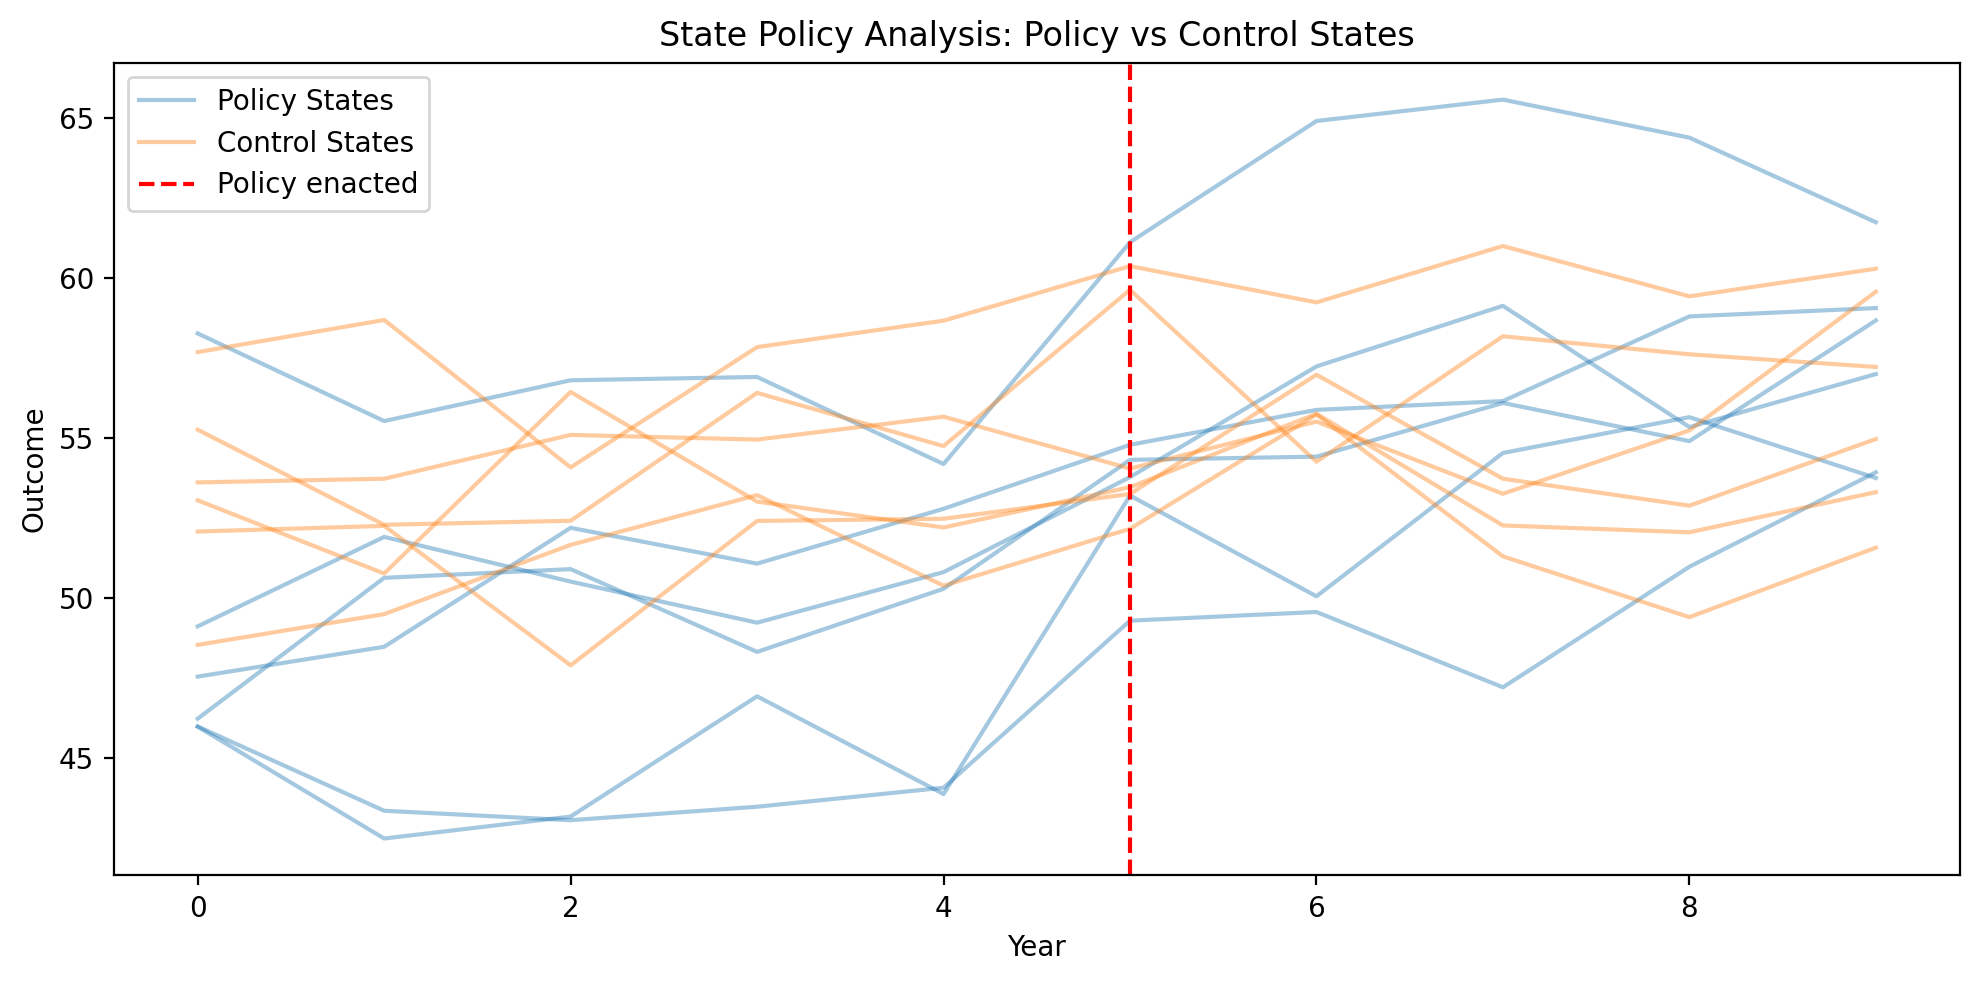

In [18]:
# Visualize state policy data
fig, ax = plt.subplots(figsize=(10, 5))

# Add treatment group indicator (states A-F get policy, G-L don't)
df_states["group"] = df_states["state"].apply(
    lambda x: "Policy States" if ord(x.split("_")[1]) - 65 < 6 else "Control States"
)

sns.lineplot(
    data=df_states,
    x="year",
    y="outcome",
    hue="group",
    units="state",
    estimator=None,
    alpha=0.4,
    ax=ax,
)
ax.axvline(x=policy_year, color="red", linestyle="--", label="Policy enacted")
ax.set_xlabel("Year")
ax.set_ylabel("Outcome")
ax.set_title("State Policy Analysis: Policy vs Control States")
ax.legend()
plt.tight_layout()

In [19]:
# Fit panel regression with state and year FE (Bayesian)
result_states = cp.PanelRegression(
    data=df_states,
    formula="outcome ~ C(state) + C(year) + policy + gdp_growth",
    unit_fe_variable="state",
    time_fe_variable="year",
    fe_method="dummies",
    model=cp.pymc_models.LinearRegression(sample_kwargs=sample_kwargs),
)

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta, y_hat_sigma]


Output()

Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 2 seconds.
Sampling: [beta, y_hat, y_hat_sigma]
Sampling: [y_hat]


In [20]:
result_states.summary()


Panel Regression
Units: 12 (state)
Periods: 10 (year)
FE method: dummies
Observations: 120

Note: 20 fixed effect coefficients not shown (use print_coefficients() to see all)

Model Coefficients (excluding FE dummies):
Model coefficients:
    Intercept    45, 94% HDI [44, 46]
    policy       5, 94% HDI [3.9, 6.1]
    gdp_growth   0.49, 94% HDI [0.35, 0.63]
    y_hat_sigma  1.6, 94% HDI [1.4, 1.8]


### Visualizations

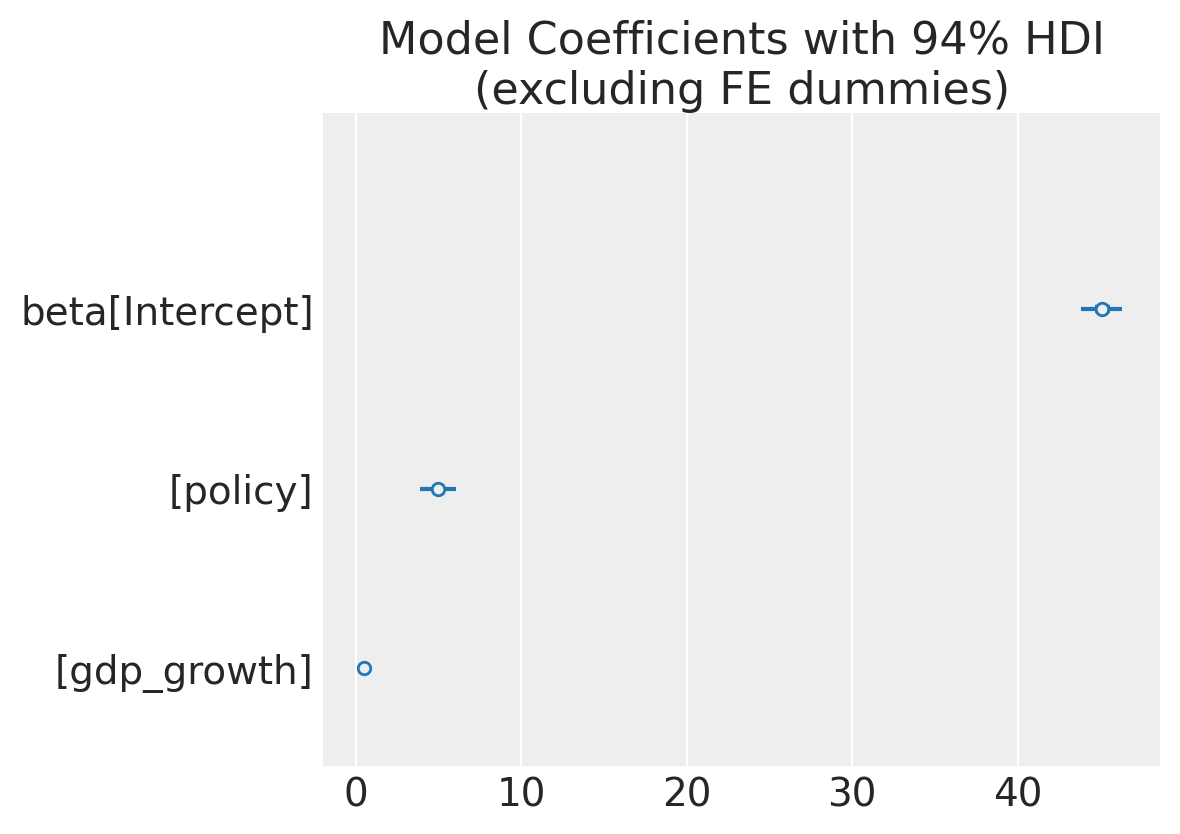

In [21]:
# Coefficient plot
fig, ax = result_states.plot_coefficients()
plt.tight_layout()
plt.show()

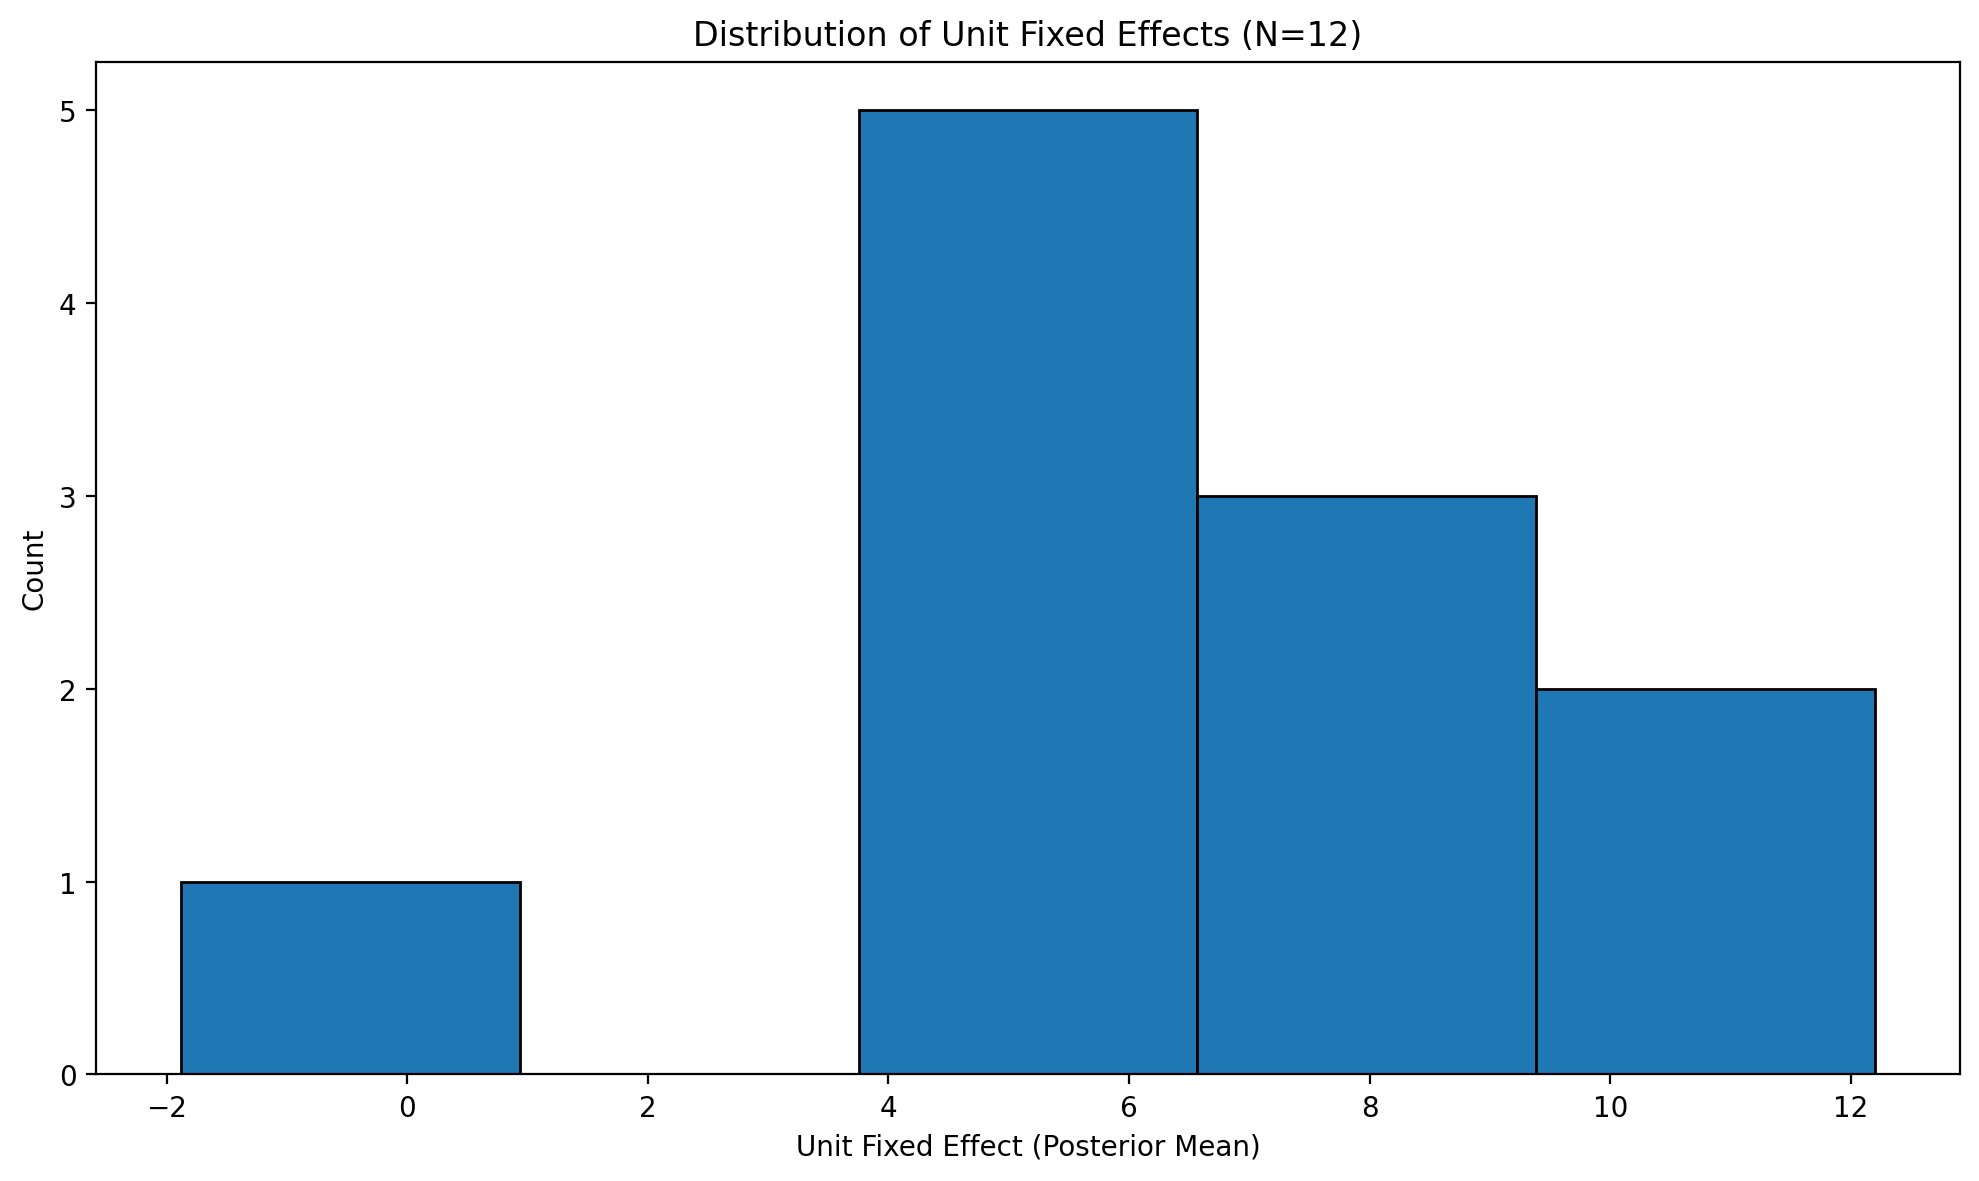

In [22]:
# Distribution of state fixed effects
fig, ax = result_states.plot_unit_effects()
plt.tight_layout()
plt.show()

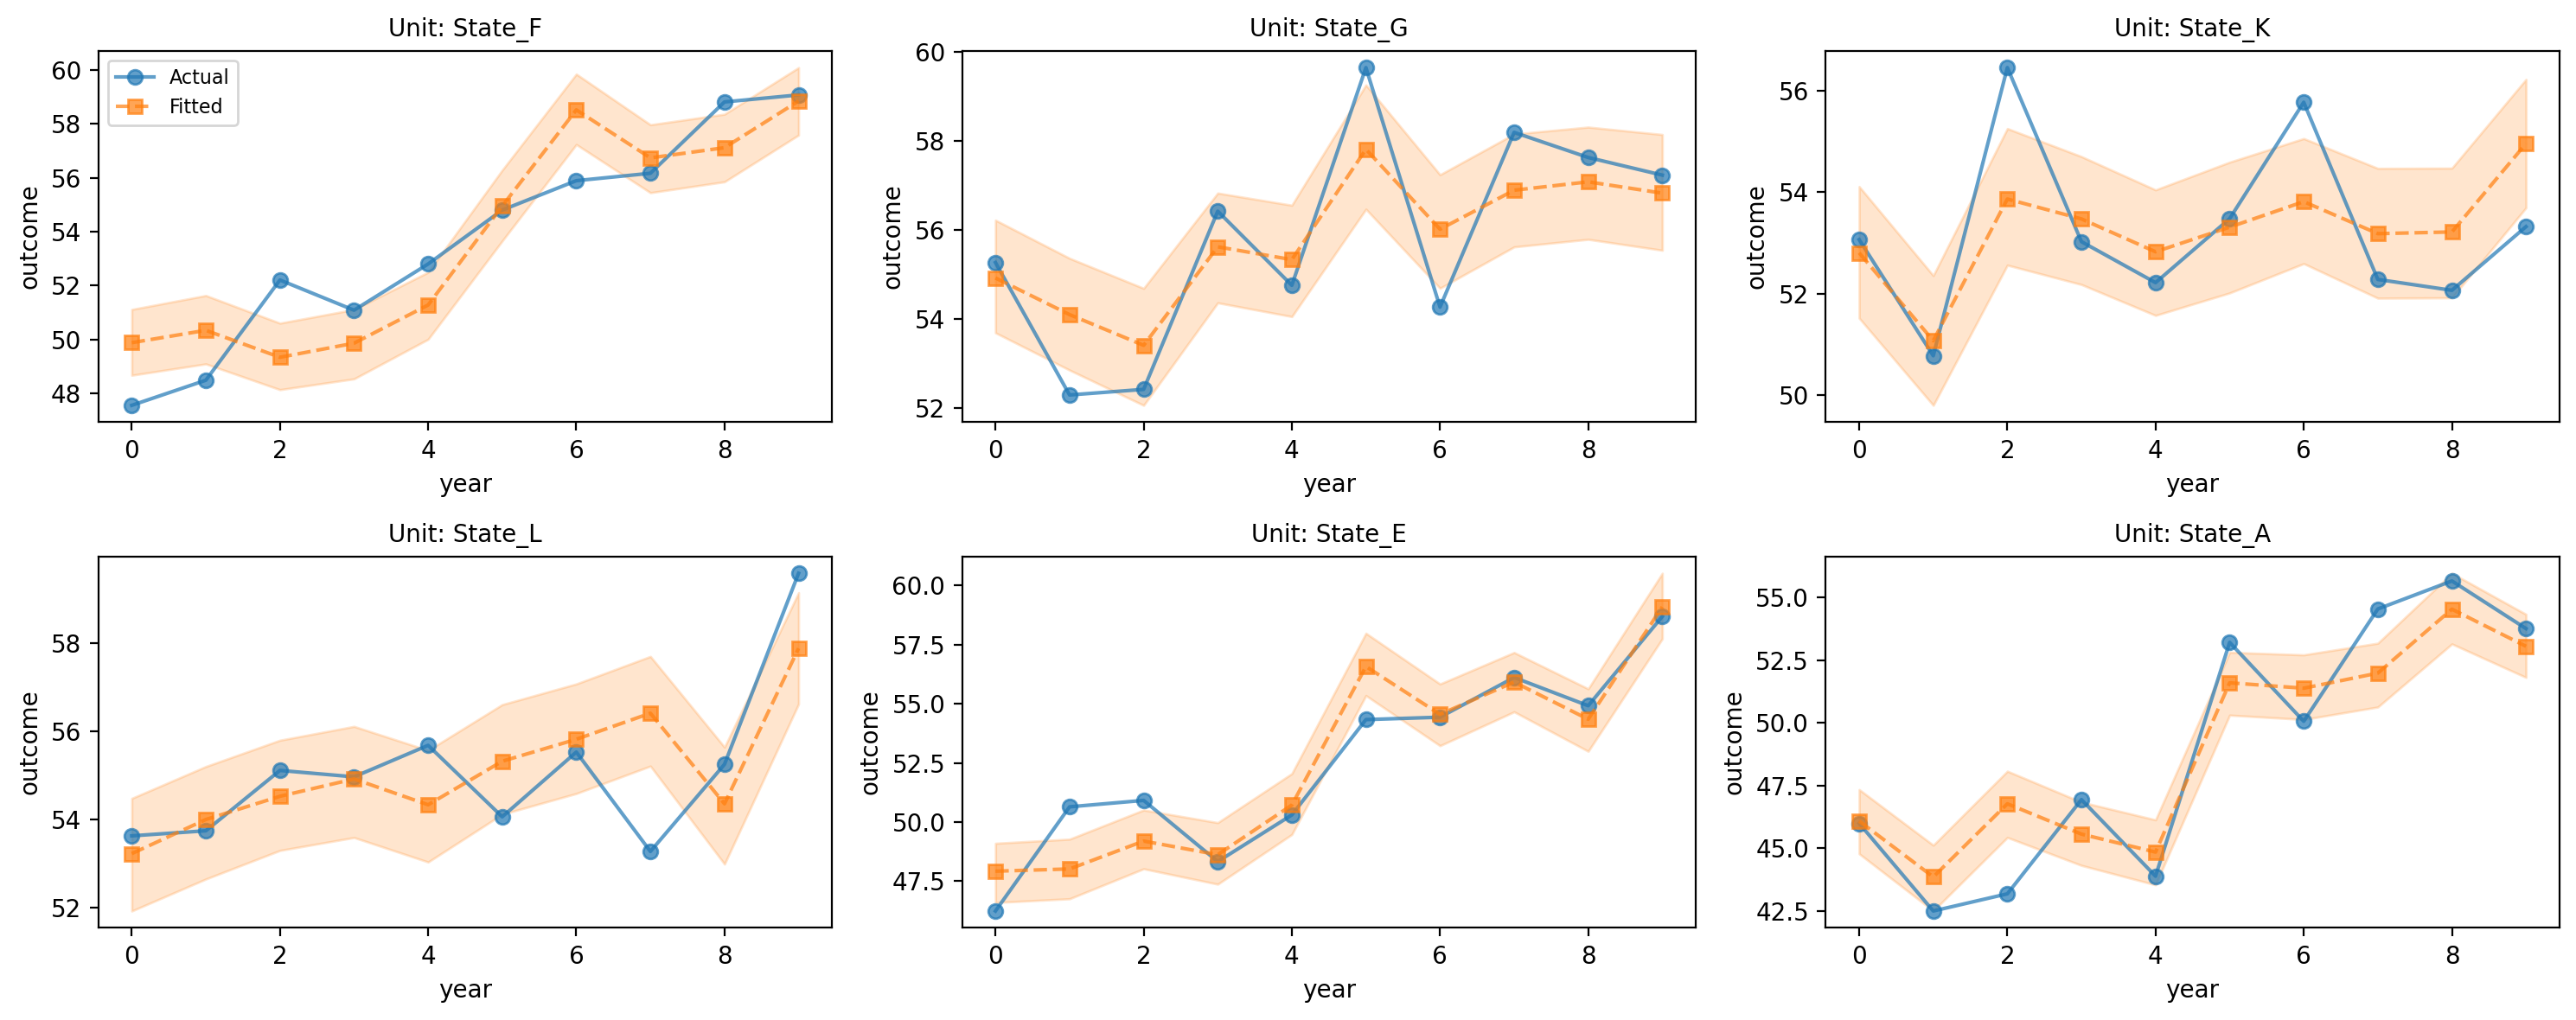

In [23]:
# State trajectories
fig, axes = result_states.plot_trajectories(n_sample=6)
plt.tight_layout()
plt.show()

## Example 4: Two-Way FE with Large Panel (Within Transformation)

This example demonstrates **two-way fixed effects using the within transformation** - the efficient approach for large panels where dummy variables would be impractical.

**Causal Question:** What is the effect of job training on worker productivity?

This is our motivating example from the introduction! Workers who receive training may differ in unobserved ability - the classic selection problem.

**Why two-way FE here?**
- **Worker FE:** Controls for innate ability (time-invariant)
- **Wave FE:** Controls for economy-wide conditions affecting all workers

**Assumptions we're making:**
- Innate ability is time-invariant (plausible)
- No time-varying confounders (e.g., no unobserved motivation shocks)
- Training doesn't respond to recent productivity changes

For large panels, the within transformation is more practical than dummy variables.

In [24]:
# Simulate worker panel
np.random.seed(456)

n_workers = 200
n_waves = 8
training_wave = 4

worker_data = []
for w in range(n_workers):
    worker_id = f"worker_{w:04d}"
    ability = np.random.randn() * 3

    for wave in range(n_waves):
        trained = 1 if (wave >= training_wave and w < n_workers * 0.4) else 0
        experience = wave * 0.5 + np.random.randn() * 0.2

        productivity = (
            ability + 2.5 * trained + 0.3 * experience + np.random.randn() * 0.8
        )

        worker_data.append(
            {
                "worker_id": worker_id,
                "wave": wave,
                "trained": trained,
                "experience": experience,
                "productivity": productivity,
            }
        )

df_workers = pd.DataFrame(worker_data)
print(f"Worker panel: {n_workers} workers, {n_waves} waves")
df_workers.head()

Worker panel: 200 workers, 8 waves


,worker_id,wave,trained,experience,productivity
0,worker_0000,0,0,-0.099642,-1.539417
1,worker_0000,1,0,0.613738,-0.739856
2,worker_0000,2,0,1.325918,-1.365037
3,worker_0000,3,0,1.589897,-1.804065
4,worker_0000,4,1,1.936954,-0.536076


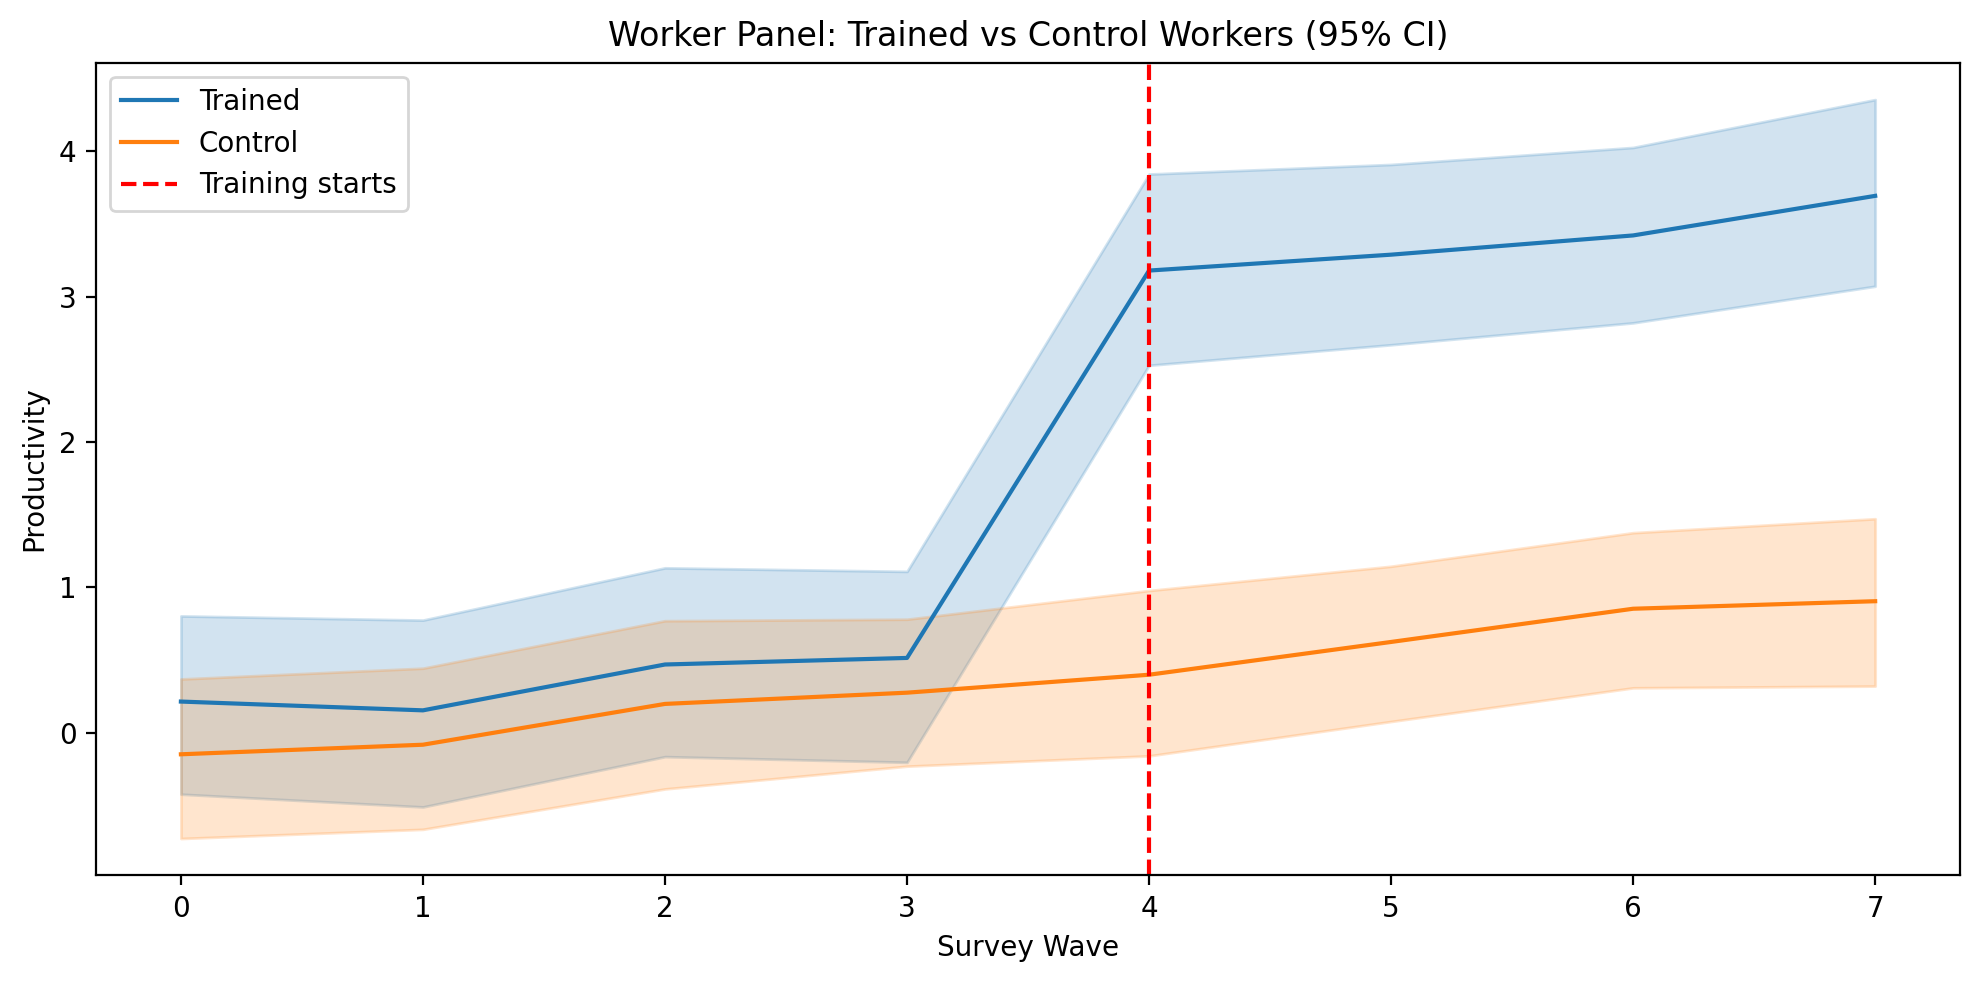

In [25]:
# Visualize worker training data
fig, ax = plt.subplots(figsize=(10, 5))

# Add treatment group indicator (first 40% = workers 0-79 are trained)
df_workers["group"] = df_workers["worker_id"].apply(
    lambda x: "Trained" if int(x.split("_")[1]) < 80 else "Control"
)

# Use CI instead of individual lines for large N (200 workers)
sns.lineplot(
    data=df_workers,
    x="wave",
    y="productivity",
    hue="group",
    errorbar=("ci", 95),
    ax=ax,
)
ax.axvline(x=training_wave, color="red", linestyle="--", label="Training starts")
ax.set_xlabel("Survey Wave")
ax.set_ylabel("Productivity")
ax.set_title("Worker Panel: Trained vs Control Workers (95% CI)")
ax.legend()
plt.tight_layout()

In [26]:
# Two-way FE with within transformation (Bayesian)
# Both worker_id and wave are used for fixed effects
result_workers = cp.PanelRegression(
    data=df_workers,
    formula="productivity ~ trained + experience",
    unit_fe_variable="worker_id",  # Worker FE
    time_fe_variable="wave",  # Time FE (survey waves)
    fe_method="within",
    model=cp.pymc_models.LinearRegression(sample_kwargs=sample_kwargs),
)

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta, y_hat_sigma]


Output()

Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 1 seconds.
Sampling: [beta, y_hat, y_hat_sigma]
Sampling: [y_hat]


In [27]:
result_workers.summary()


Panel Regression
Units: 200 (worker_id)
Periods: 8 (wave)
FE method: within
Observations: 1600

Model Coefficients (excluding FE dummies):
Model coefficients:
    Intercept    6.8e-05, 94% HDI [-0.035, 0.035]
    trained      2.4, 94% HDI [2.3, 2.6]
    experience   0.2, 94% HDI [0.01, 0.39]
    y_hat_sigma  0.76, 94% HDI [0.74, 0.79]


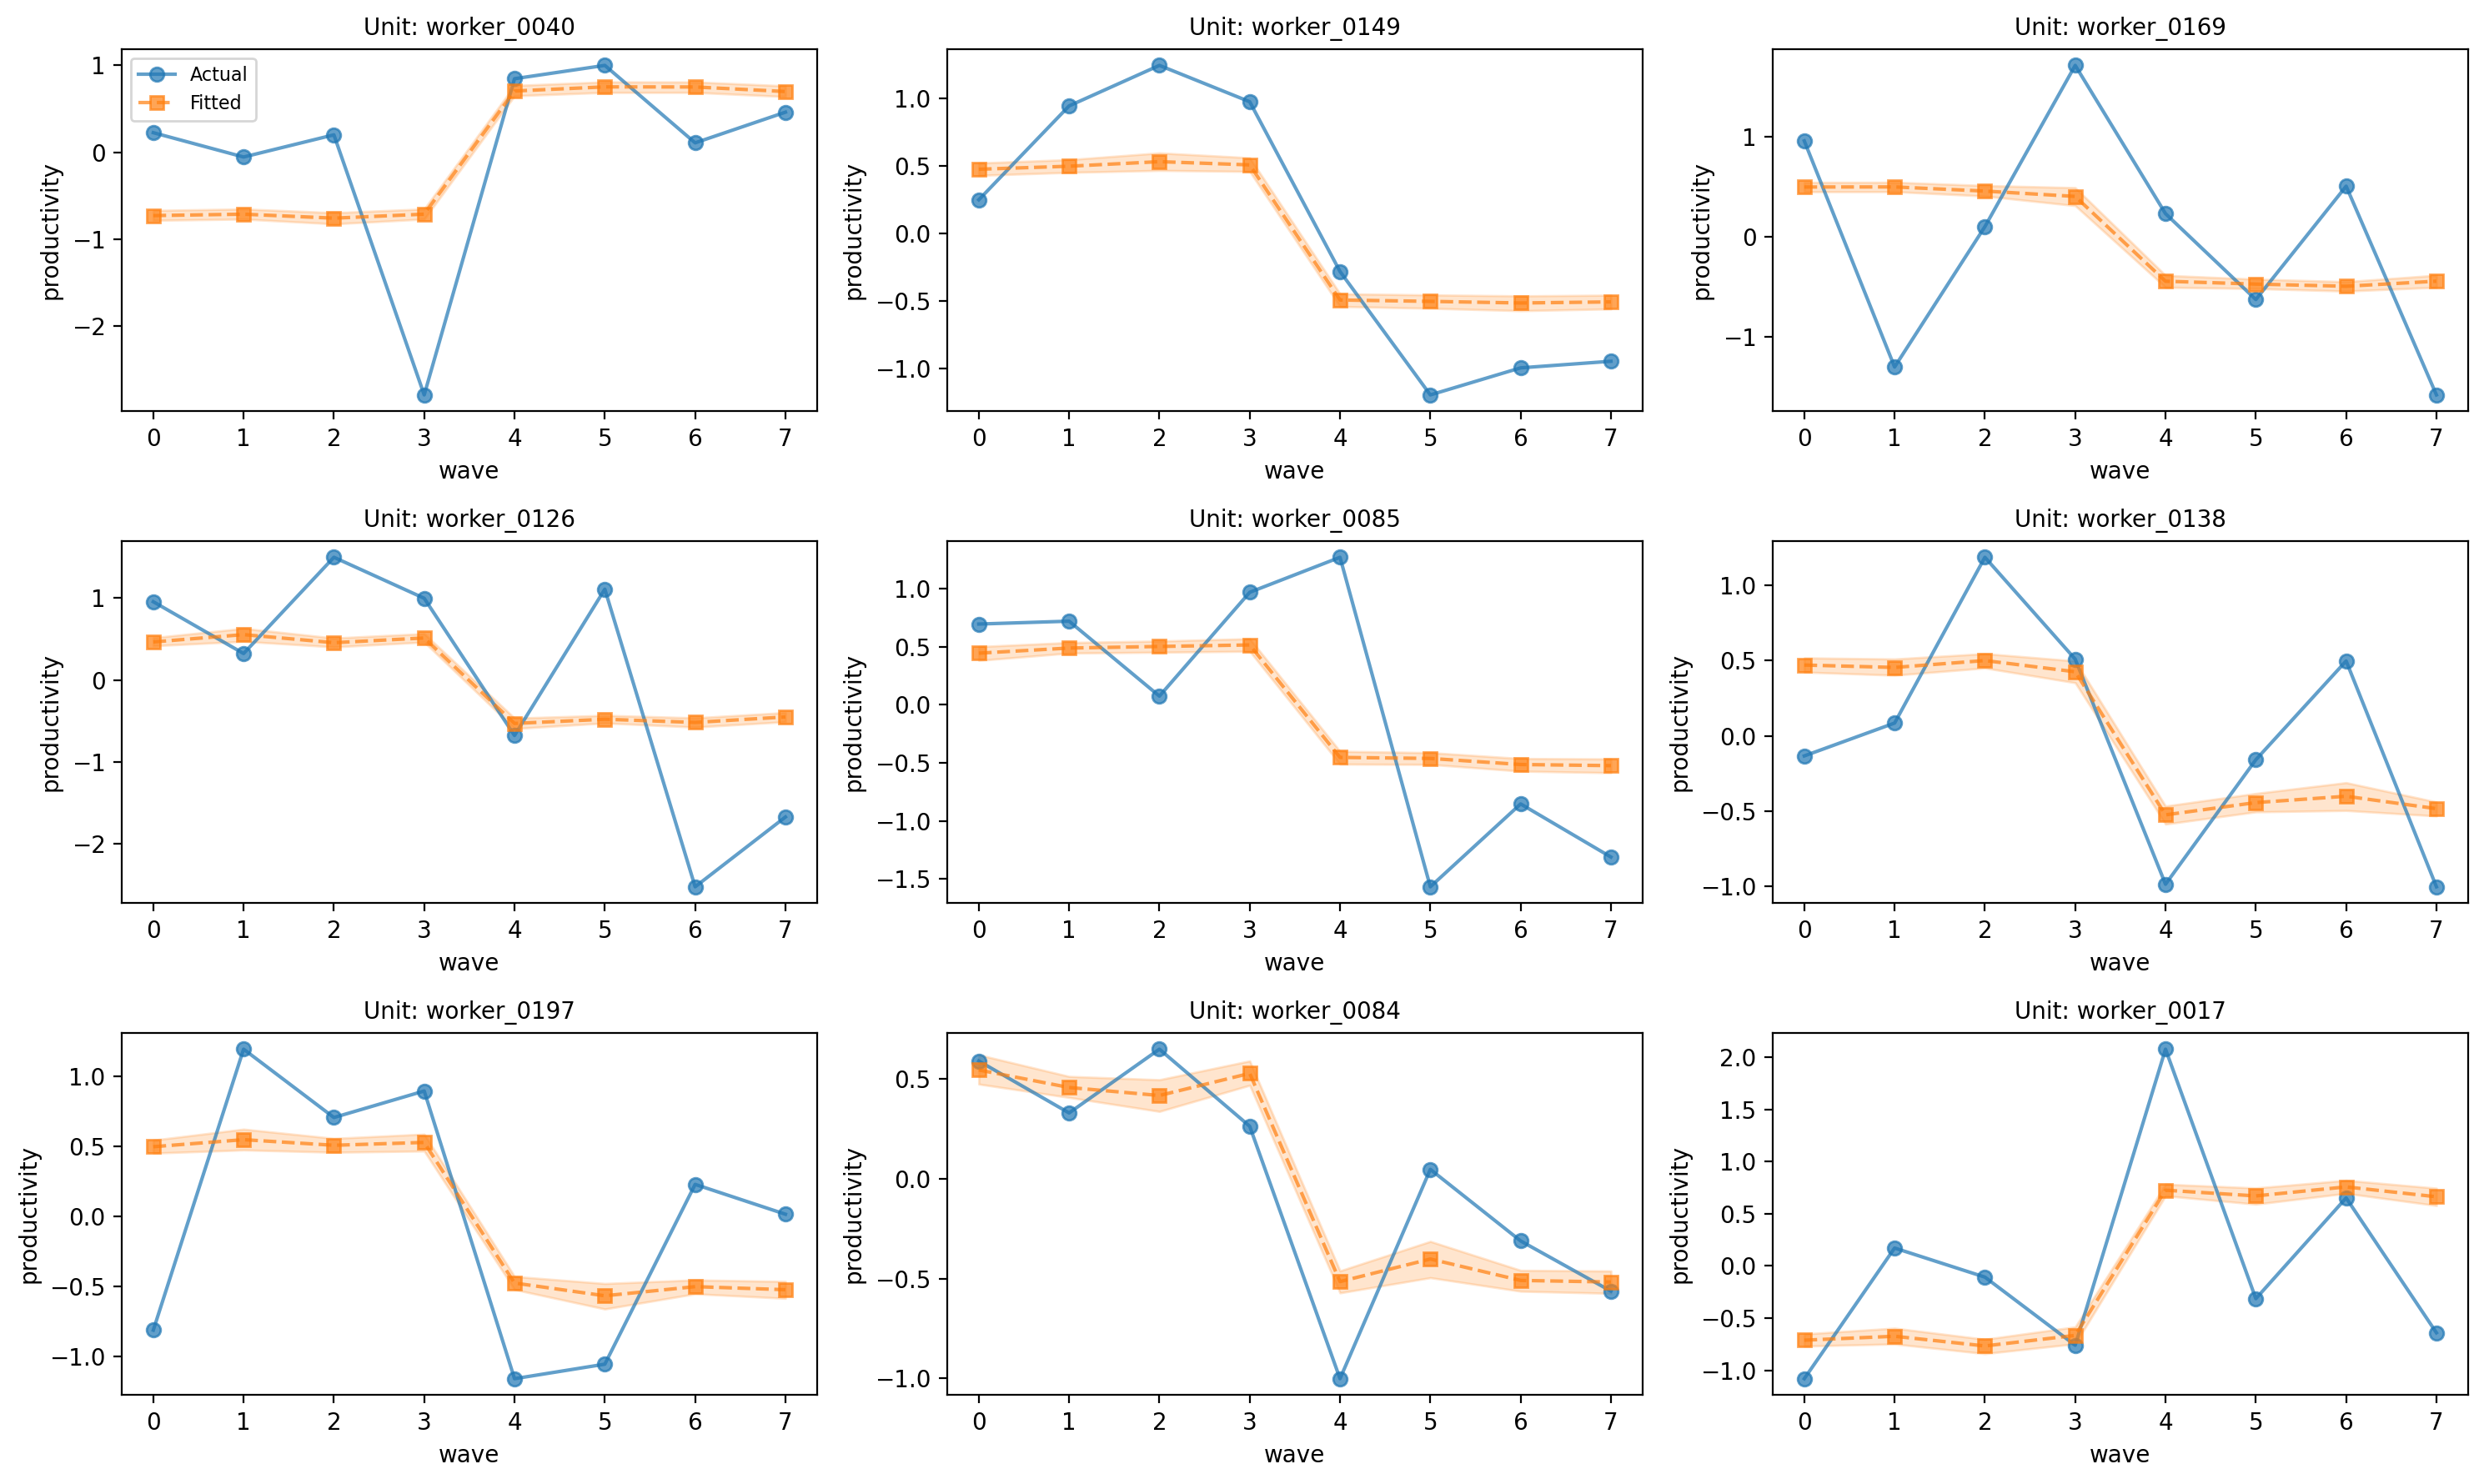

In [28]:
# Worker trajectories
fig, axes = result_workers.plot_trajectories(n_sample=9)
plt.tight_layout()
plt.show()

## Diagnostics

Always check model diagnostics!

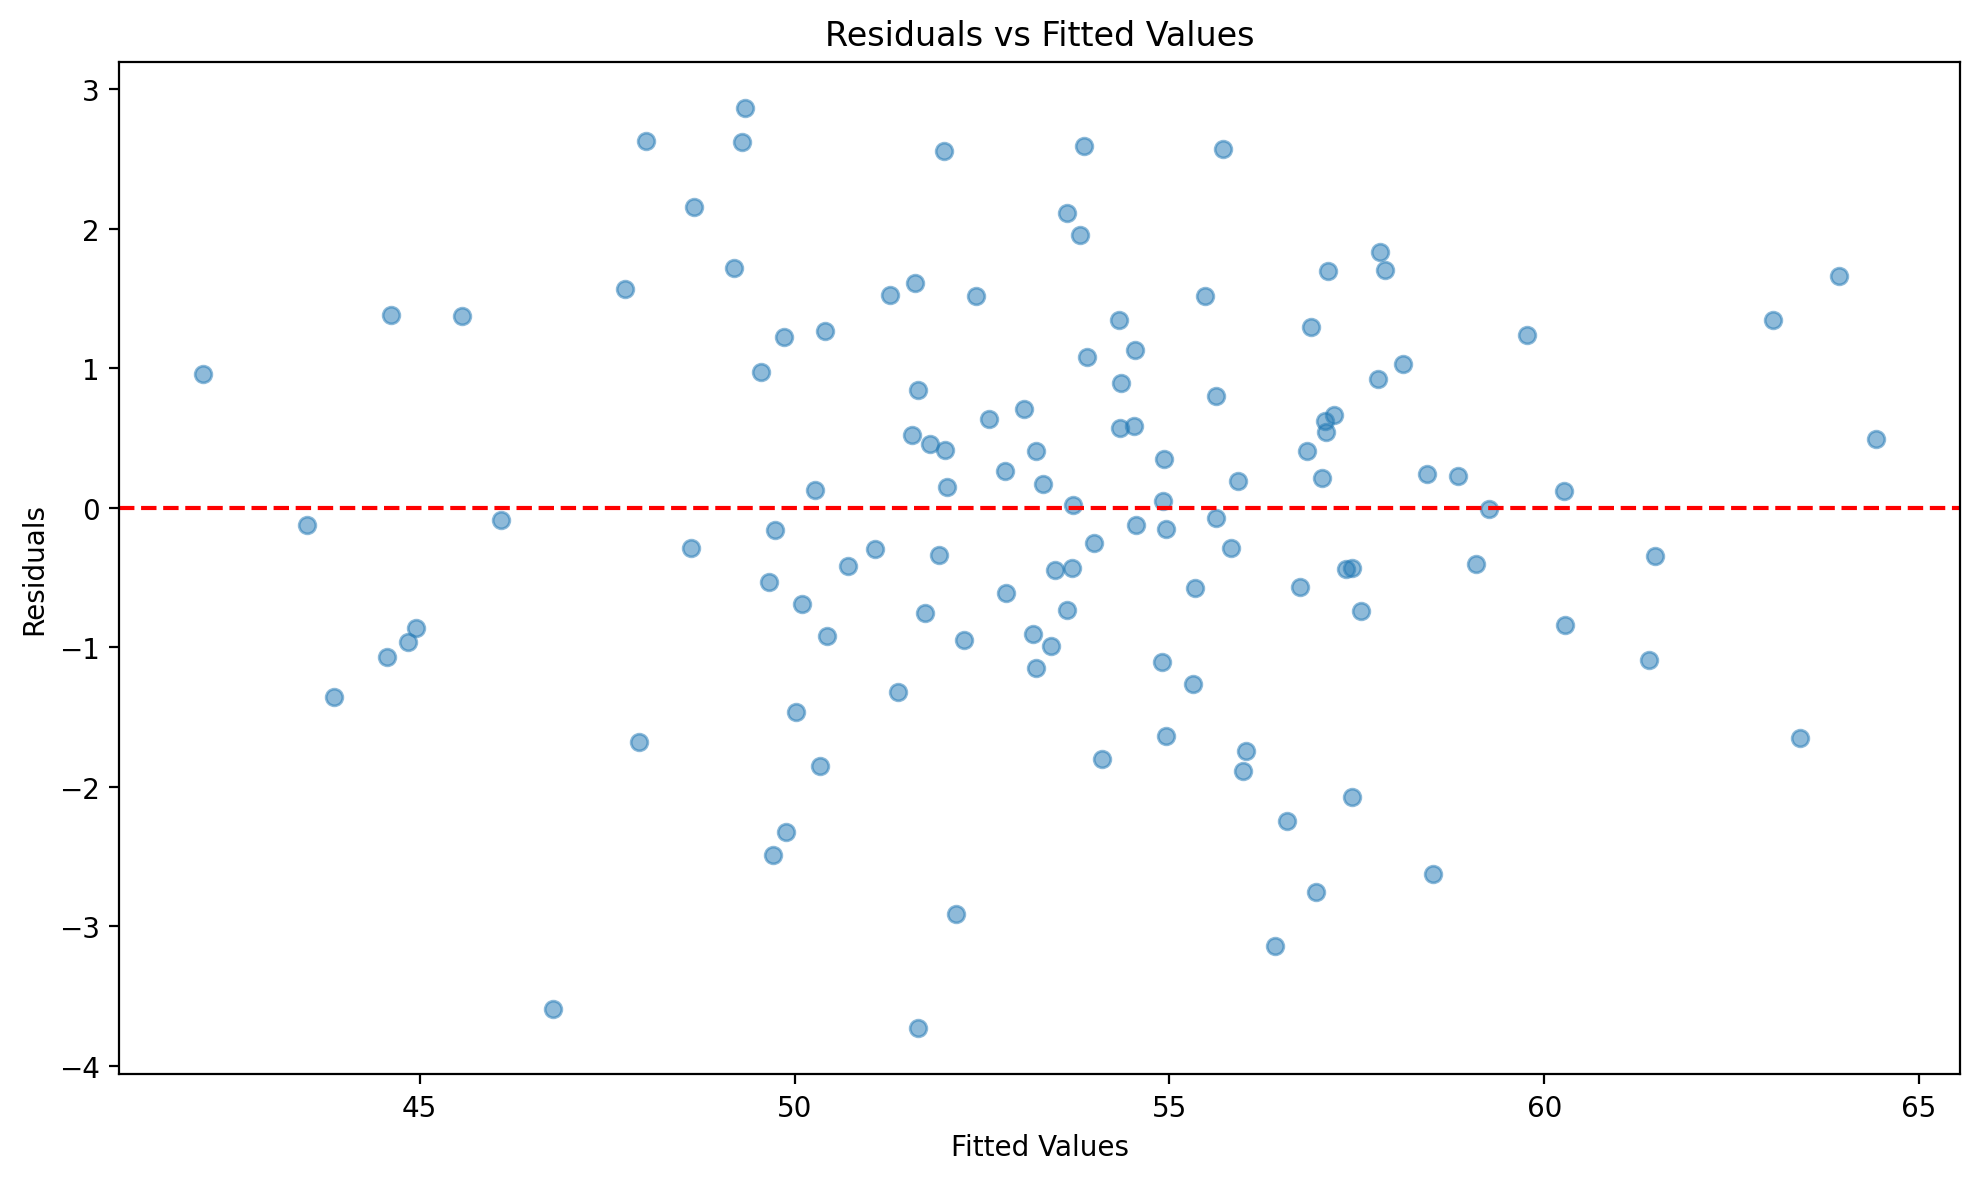

In [29]:
# Residuals vs fitted
fig, ax = result_states.plot_residuals(kind="scatter")
plt.tight_layout()
plt.show()

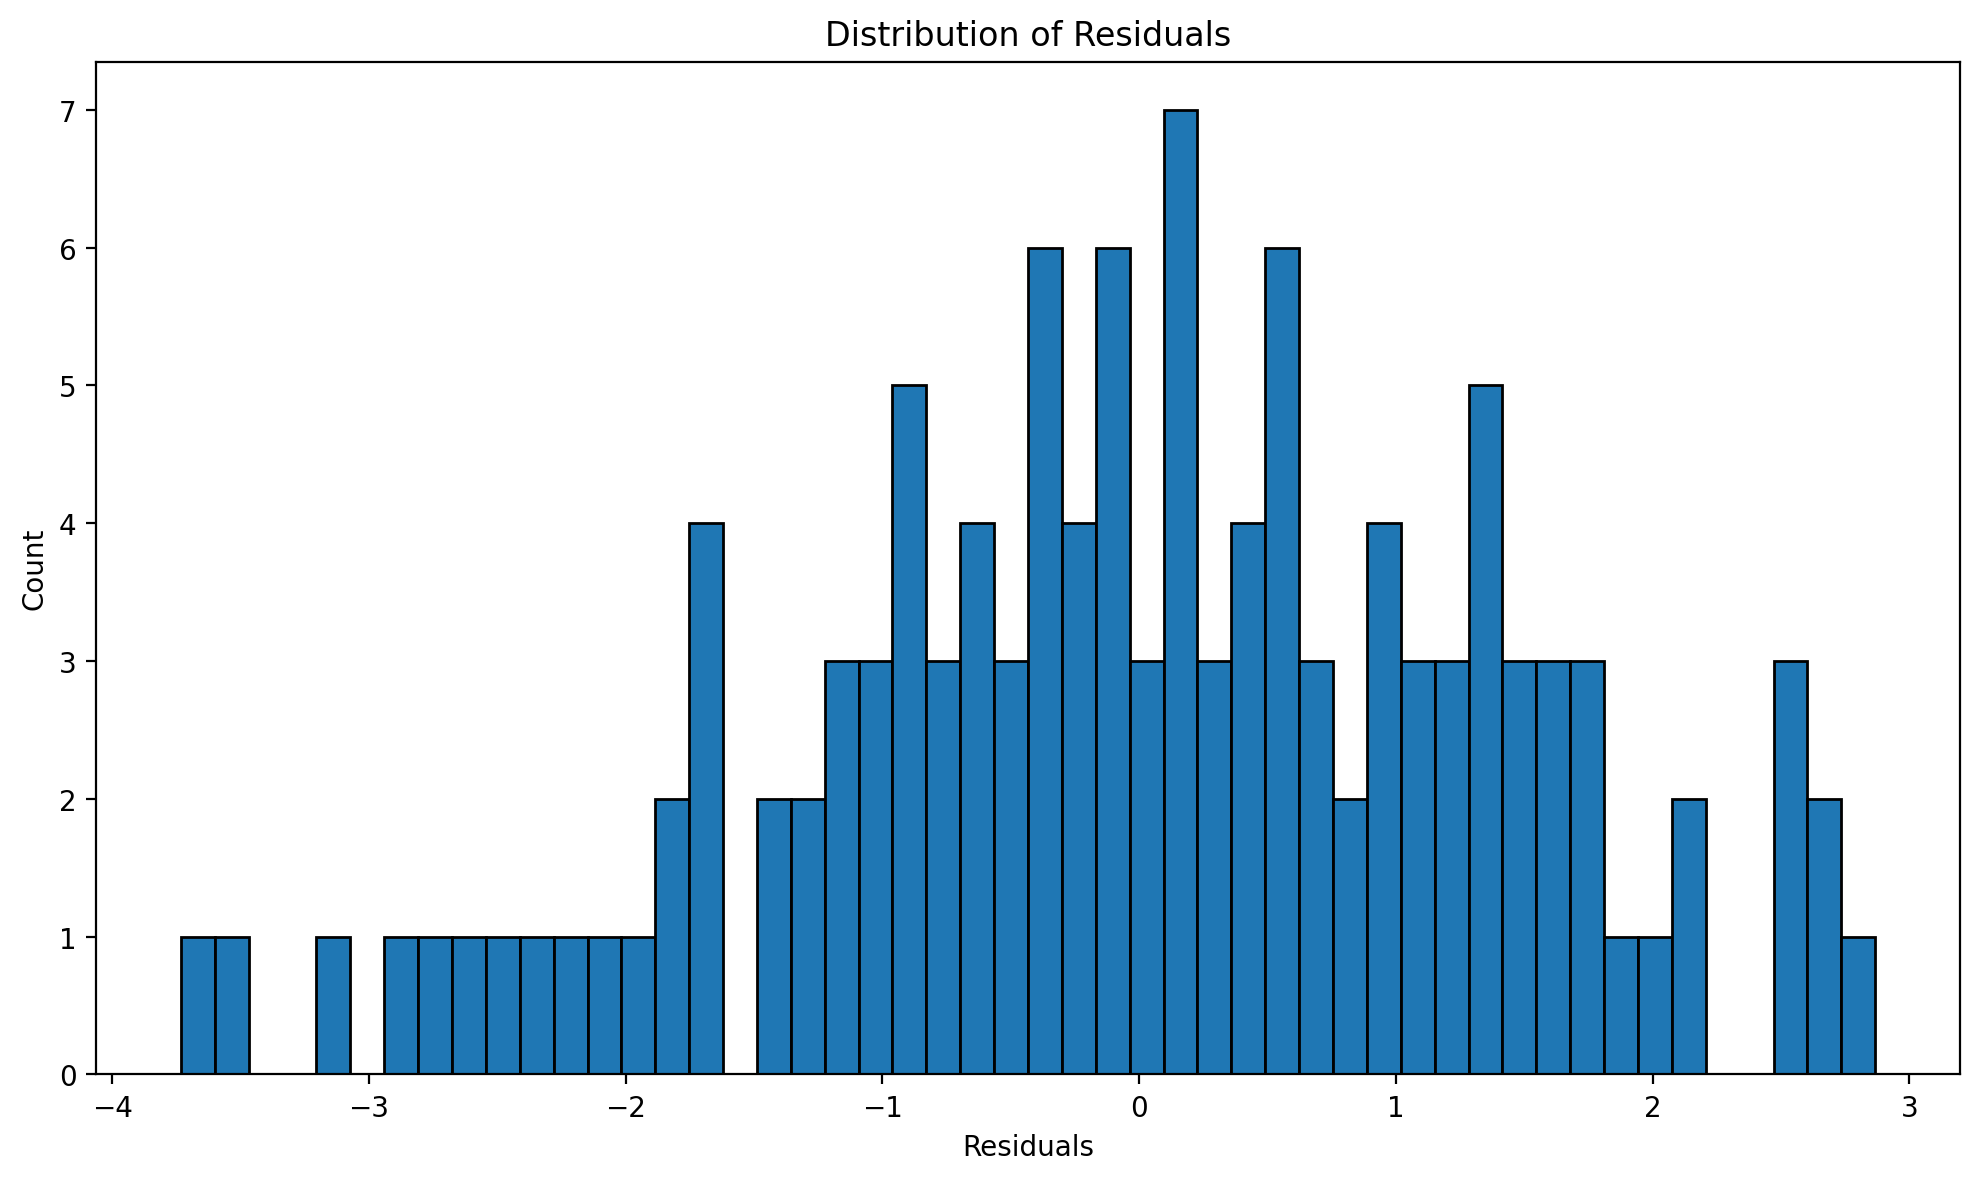

In [30]:
# Distribution of residuals
fig, ax = result_states.plot_residuals(kind="histogram")
plt.tight_layout()
plt.show()

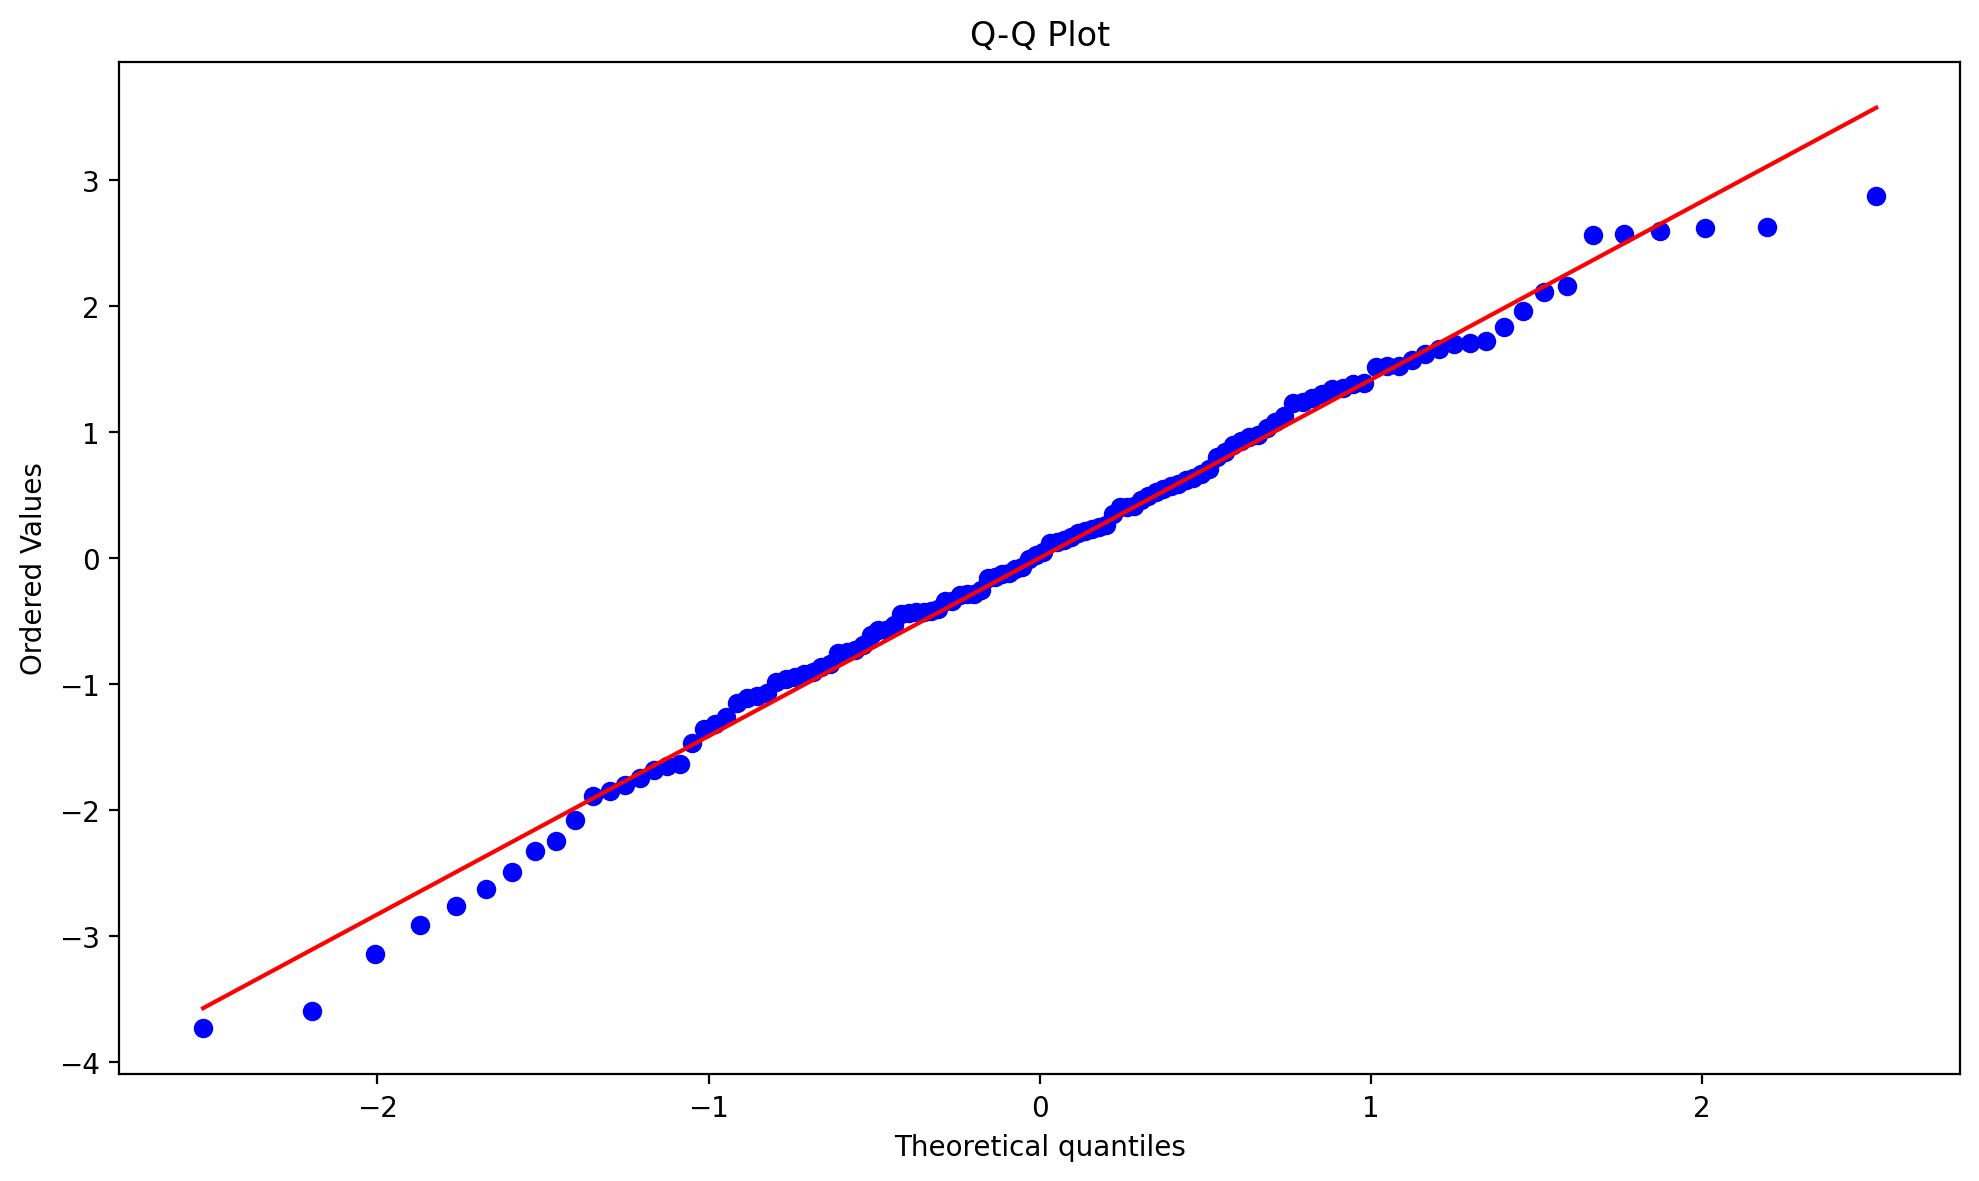

In [31]:
# Q-Q plot
fig, ax = result_states.plot_residuals(kind="qq")
plt.tight_layout()
plt.show()

## Choosing Your Fixed Effects Specification

Use this guide to select the appropriate fixed effects for your analysis:

| Scenario | Recommended FE | Rationale |
|----------|---------------|-----------|
| Units differ in time-invariant ways only | **Unit FE only** | Controls for unit heterogeneity; preserves time variation |
| All units experience common shocks each period | **Time FE only** | Controls for period effects; preserves cross-sectional variation |
| Both unit heterogeneity AND common time trends | **Two-way FE** | Controls for both; standard for DiD-style analyses |
| Time effects already captured by covariates | **Unit FE only** | Avoid over-controlling |
| Treatment is staggered across units | **Two-way FE** | Essential for valid DiD interpretation |

Key Considerations

1. **More FE is not always better:** Adding fixed effects removes variation that could be useful for identification. Over-controlling can increase standard errors and even introduce bias.

2. **Think about your DAG:** What confounders exist? Are they time-invariant (unit FE), common across units (time FE), or both?

3. **Treatment variation matters:** 
   - If treatment only varies across units (not time), unit FE will absorb all treatment variation!
   - If treatment only varies over time (not units), time FE will absorb all treatment variation!

4. **Test sensitivity:** When in doubt, run both one-way and two-way FE. If results differ substantially, investigate why.


### Dummies vs Within

| Criterion | Dummies | Within |
|-----------|---------|--------|
| **When** | Small N (< 100) | Large N (100+) |
| **Pros** | Individual unit effects | Scales to large N |
| **Cons** | Doesn't scale | Can't estimate individual effects |
| **Formula** | `y ~ C(unit) + X` | `y ~ X` |

## Limitations and Caveats

Before concluding, let's be explicit about what fixed effects **cannot** do:

* 1. **Cannot Remove Time-Varying Confounders:** As demonstrated in our failure example, if unobserved factors change over time and affect both treatment and outcome, fixed effects will be biased. This is the most common limitation.

* 2. **Cannot Solve Reverse Causality:** If the outcome affects future treatment (feedback), fixed effects estimates are biased. Example: if poor sales cause firms to adopt new technology, we cannot estimate the effect of technology on sales using FE.

* 3. **Removes Time-Invariant Variation:** Fixed effects identifies effects from **within-unit variation only**. If your treatment barely varies within units, you have limited identifying variation and imprecise estimates.

* 4. **Assumes Common Time Effects (Two-Way FE):** With time fixed effects, you assume all units would follow parallel trends absent treatment. This may not hold if different units have different trajectories.

## Summary

✅ **Use Panel Fixed Effects when:**
- You have repeated observations on the same units
- You suspect **time-invariant** unobserved confounders
- Your treatment varies within units over time
- You believe there are no time-varying confounders

❌ **Don't use when:**
- You only have cross-sectional data
- Your treatment is time-invariant (it gets differenced out!)
- There are likely time-varying confounders
- Outcomes feed back into future treatment

## References

:::{bibliography}
:filter: docname in docnames
:::
